In [1]:
# Implementation of core Gradient Descent optimization algorithm

# importing necessary libraries

import jax
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import numdifftools as nd
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["figure.autolayout"] = True

import random
np.random.seed(69)
random.seed(69)


# Truss

In [2]:
# defining the geometery of truss

E = 1e7 #68947572.93178 # KN/m^2 (10e7 psi) modulus_of_elasticity
p = 0.1  #27.1447138 # KN/m^3 (0.1 lb/in^3) weight_density
s_lim = 25000.0 #172368.93233 #KN/m^2 (25000 psi) # allowable_stress_compression = 172368.93233 #KN/m^2 (25000 psi)
d_lim =  2.0 #0.0508 #m (2 inch) #displacemnt limit

In [3]:
area_avalival = [1.62, 1.80,2.38, 2.62, 2.88, 3.09, 3.13,
3.38,3.63,3.84,3.87,4.18,4.49,4.80,4.97,5.12, 5.74, 7.22,
7.97,11.5,13.5,13.9,14.2,15.5,16.0,18.8,19.9,22.0,22.9,
26.5, 30.0, 33.5]  ## sq inch

In [4]:
nodes, bars =[], []

nodes.append([100,460]) #node0
nodes.append([460,460]) #node1
nodes.append([820,460]) #node2
nodes.append([100,100]) #node3
nodes.append([460,100]) #node4
nodes.append([820,100]) #node5

bars.append([0,1]) #bar1  #dont forget python starts with 0
bars.append([1,2]) #bar2

bars.append([3,4]) #bar3
bars.append([4,5]) #bar4


bars.append([1,4]) #bar5
bars.append([2,5]) #bar6

bars.append([0,4]) #bar7
bars.append([1,3]) #bar8

bars.append([1,5]) #bar9
bars.append([2,4]) #bar10

nodes = np.array(nodes).astype(float)
bars = np.array(bars)
original_nodes = np.copy(nodes)

In [5]:
bars, nodes

(array([[0, 1],
        [1, 2],
        [3, 4],
        [4, 5],
        [1, 4],
        [2, 5],
        [0, 4],
        [1, 3],
        [1, 5],
        [2, 4]]),
 array([[100., 460.],
        [460., 460.],
        [820., 460.],
        [100., 100.],
        [460., 100.],
        [820., 100.]]))

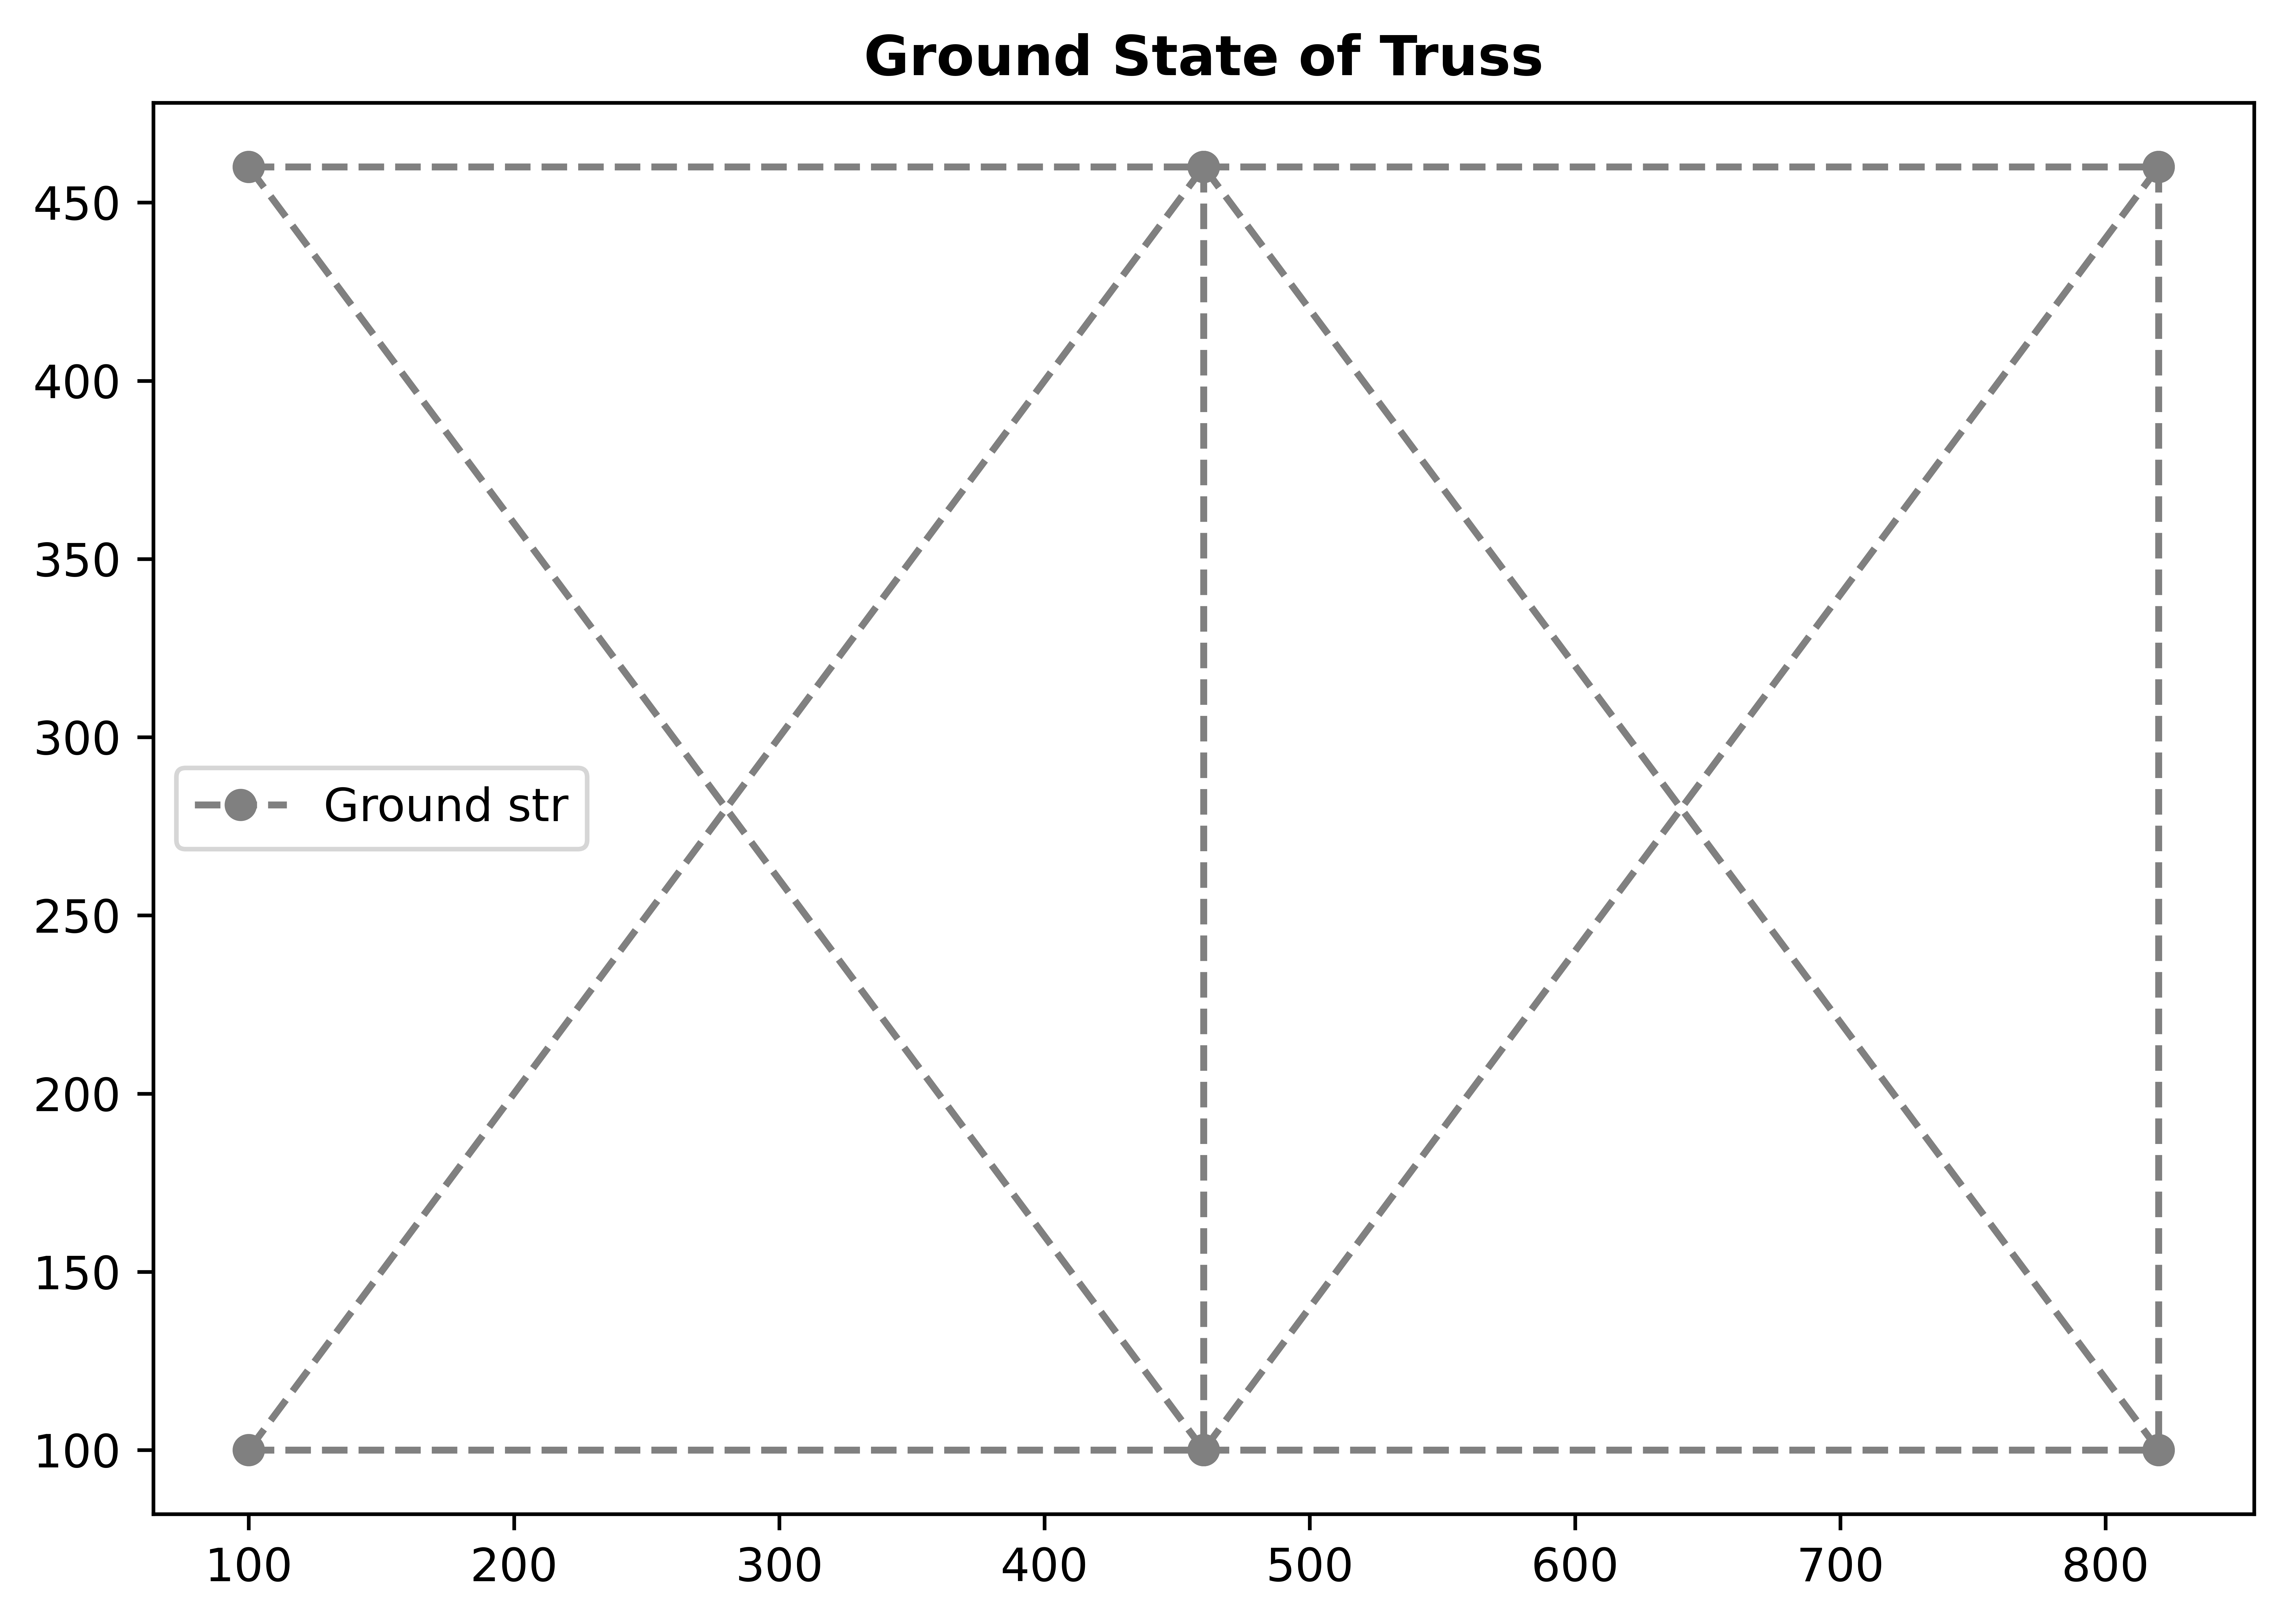

In [6]:
plt.figure(figsize=(7,5))
plt.title("Ground State of Truss", fontweight='bold')
for i in range(len(bars)):
    xi, xf = nodes[bars[i,0],0], nodes[bars[i, 1],0]
    yi, yf = nodes[bars[i, 0], 1], nodes[bars [i, 1],1]
    line, = plt.plot([xi, xf], [yi, yf], color='grey', linestyle='--', marker='o') 

line.set_label('Ground str')
plt.legend()
plt.show()

In [7]:
P = np.zeros_like(nodes) # 0 =nO LOAD # 1 == lOAD
P[4,1]= -100000
P[5,1]= -100000
print(P)

[[      0.       0.]
 [      0.       0.]
 [      0.       0.]
 [      0.       0.]
 [      0. -100000.]
 [      0. -100000.]]


In [8]:
Ur = [0,0,0,0]

In [9]:
# Defining the degrees of Freedoms
DOFCON = np.ones_like(nodes).astype(int)
DOFCON[0,:] = 0
DOFCON[3,:] = 0
print(DOFCON)

[[0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]]


In [10]:
# Truss Analysis
# Doing structural analysis of the truss for an constant area of 11.5 inch^2

In [11]:
@jax.jit
class basic(): 

    def min_area(area):
        computed_area =[]
        for i in area:
            if i<1:
                computed_area.append(1)
            else:
                computed_area.append(i)
        return np.array(computed_area)

    def area_gen(area):
        area_new = []
        for i in range(10):
            area_new.append(random.choice(area))
        return area_new

    def scaler(area):
        f=[]
        a = sum(area)
        for i in area:
            i=i*50
            f.append(i/a)
        return f

    def Plot(nodes, c, lt, area, lg):
        for i in range(len(bars)):
            xi, xf = nodes[bars[i,0],0], nodes[bars[i,1],0]
            yi, yf = nodes[bars[i,0],1], nodes[bars[i,1],1]
            a = np.round(basic.scaler(area), 3)
            line, = plt.plot([xi, xf], [yi,yf], color=c, linestyle=lt, linewidth=a[i],
                             label=f'\nArea : {area[i]} in^2\n', marker='o', solid_capstyle='round') #
        line, = plt.plot([xi, xf], [yi,yf], color=c, linestyle=lt, linewidth=0.001, solid_capstyle='round')
        line.set_label(lg)
        plt.legend(bbox_to_anchor=(1,1), loc="upper left", prop={'size':4})
    

    def check( STRESS, DEFLECTION):
        x=0
        y=0
        for i in STRESS:
            if (np.abs(i) > s_lim).all():
                x +=1
                # print("Failed in Stress")
            else:
                pass
                #print("Pass in Stress")
        for i in range(6):
            ix = np.abs(DEFLECTION[i][0])
            iy = np.abs(DEFLECTION[i][1])
            if (ix > d_lim).all():
                y+=1
                #print("Failed in Deflection along X")
            elif (iy > d_lim).all():
                y +=1
                #print("Failed in Deflection along Y")
            else:
                pass
                #print("Pass in Deflection")
        if (x ==0) and (y==0):
            # print("Pass")
            return "Pass"
        else:
            # print(f'Failed in {x} ways for stress \n Failed in {y} ways for deflection ')
            return f'Failed in {x} ways for stress \n Failed in {y} ways for deflection '

@jax.jit
class Truss():
    # Truss Structural Analysis
    def TrussAnalysis(A, nodes, bars):
        NN = len(nodes) # number of nodes
        NE = len(bars) # number of deges
        # print(NE)

        DOF = 2 # defree of freedom
        NDOF = DOF*NN # total degree of freedom

        #structural analysis using direct stifness method

        # for bar no 3
        # takes info from node no 3 and substract it from infor of node no 2
        d = nodes[bars[:,1],:] - nodes[bars[:,0],:]
        
        L = np.sqrt((d**2).sum(axis=1)) #leangth of the bar
        # print(f"The Leangth is {L}")
        #computing the angle 
        angle = d.T/L
        # print(f"The angle is \n\n{angle}\n\n")
        #transformation vector {a ==Transformation vector}
        a = np.concatenate((-angle.T, angle.T), axis=1)
        # print(f"The transformation vector is \n\n{a}\n\n")

        #Global stifness matrix K
        K = np.zeros([NDOF,NDOF])
        
        
        for k in range(NE):
            aux = 2*bars[k,:]
            #gives you degree of freedom in each node
            index = np.r_[aux[0]:aux[0]+2, aux[1]:aux[1]+2]
            # print(f'a : {a.shape}, A: {A.shape}, L: {L.shape}')
            ES = np.dot(a[k][np.newaxis].T*E*A[k], a[k][np.newaxis])/L[k]
            # print(f"Stifness Matrix \n\n{ES}\n\n")
            K[np.ix_(index,index)] = K[np.ix_(index,index)] + ES

        freeDOF = DOFCON.flatten().nonzero()[0]
        supportDOF = (DOFCON.flatten()==0).nonzero()[0]

        Kff = K[np.ix_(freeDOF, freeDOF)]
        Kfr = K[np.ix_(freeDOF, supportDOF)]
        Krf = Kfr.T
        # print(f'{Kfr}, \n \n {Kff}, \n \n {Krf}')
        Krr = K[np.ix_(supportDOF, supportDOF)]
        
        Pf = P.flatten()[freeDOF]
        #Uf = np.linalg.solve(Kff, Pf) #.lstsq
        Uf = np.linalg.inv(Kff)@ Pf
        U  = DOFCON.astype(float).flatten()
        U[freeDOF] = Uf
        U[supportDOF] = Ur

        U = U.reshape(NN, DOF) #displacement of the truss members
        u = np.concatenate((U[bars[:,0]], U[bars[:,1]]), axis=1)
        # print(E)
        # print(A)
        N = E*A[:]/L[:]*(a[:]*u[:]).sum(axis=1)
        R = (Krf[:]*Uf).sum(axis=1) + (Krr[:]*Ur).sum(axis=1) #Reaction Force
        R = R.reshape(2,DOF)

        # Stress
        S = N/A

        #weight of str
        Volume = (1*A*L).sum() #for mass replace 1 by p

        #check
        c = basic.check(S, U)

        return S, Volume, U, c, R

basic = jax.jit(basic)
Truss = jax.jit(Truss)

In [12]:
x = np.array([20 for i in range(10)]).astype(float)
x

array([20., 20., 20., 20., 20., 20., 20., 20., 20., 20.])

In [13]:
Truss.TrussAnalysis(x, nodes, bars)

(array([  9768.24934844,   2006.23161277, -10231.75065156,  -2993.76838723,
          1774.48096122,   2006.23161277,   7398.81272639,  -6743.32289734,
          4233.82785582,  -2837.23995605]),
 83929.35059634515,
 array([[ 0.        ,  0.        ],
        [ 0.35165698, -0.83717623],
        [ 0.42388131, -1.89756315],
        [ 0.        ,  0.        ],
        [-0.36834302, -0.90105754],
        [-0.47611869, -1.96978749]]),
 'Pass',
 array([[-300000.        ,  104635.01303119],
        [ 300000.        ,   95364.98696881]]))

In [23]:
loads = P

In [29]:
loads = loads.astype(float)

## Determinacy and mechanism formation

In [37]:
@jax.jit 
class O():
    
    def calculate_degree_of_freedom(nodes, bars):
        """Calculates the degree of freedom of the truss."""
        dof = 2 * len(nodes)
        for bar in bars:
            node1, node2 = nodes[bar[0]], nodes[bar[1]]
            if node1[0] == node2[0]:
                dof -= 1
            if node1[1] == node2[1]:
                dof -= 1
        return dof

    def calculate_number_of_equations(nodes, bars):
        """Calculates the number of equations of the truss."""
        eq = len(nodes) * 2 - calculate_degree_of_freedom(nodes, bars)
        return eq


    def kinematic_determinacy(nodes, bars, loads):
        """Checks the kinematic determinacy of the truss."""
        dof = O.calculate_degree_of_freedom(nodes, bars)
        eq = O.calculate_number_of_equations(nodes, loads)
        if dof == eq:
            return "Kinematically Determinate"
        else:
            return "Kinematically Indeterminate"

    def static_determinacy(nodes, bars, loads):
        """Checks the static determinacy of the truss."""
        dof = O.calculate_degree_of_freedom(nodes, bars)
        eq = O.calculate_number_of_equations(nodes, loads)
        if eq >= dof:
            return "Statically Determinate"
        else:
            return "Statically Indeterminate"


    def is_mechanism(nodes, bars):
        """Checks if the truss is a mechanism or not."""
        dof = calculate_degree_of_freedom(nodes, bars)
        eq = calculate_number_of_equations(nodes)
        if dof > eq:
            return True
        else:
            return False

In [33]:




def is_mechanism(nodes, bars):
    """Checks if the truss is a mechanism or not."""
    dof = calculate_degree_of_freedom(nodes, bars)
    eq = calculate_number_of_equations(nodes)
    if dof > eq:
        return True
    else:
        return False

# Check if the truss is a mechanism
if is_mechanism(nodes, bars):
    print("The truss is a mechanism.")
else:
    print("The truss is not a mechanism.")


The truss is not a mechanism.


In [38]:
O.static_determinacy(nodes, bars, P)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Gradient Descent

In [17]:
def f(x):
    # num = np.array([x]*10)
    return Truss.TrussAnalysis(x, nodes, bars)[1]

In [18]:
grad = nd.Gradient(f)(np.array([10]*10))

In [19]:
grad

array([360.        , 360.        , 360.        , 360.        ,
       360.        , 360.        , 509.11688245, 509.11688245,
       509.11688245, 509.11688245])

In [20]:

# x = np.random.uniform(50, 100, 10) # np.array([100. for i in range(10)]).astype(float)

def cost(x):
    ans = Truss.TrussAnalysis(x, nodes, bars)
    return ans

# def gradient(x, var): # truss_volume_derivative
#     """Function that calculates the derivative of the truss volume with respect to the variable var"""
#     h = 1e-8 # Step size
#     var_index = var - 1 # Index of the variable in the x array
    
#     x_plus_h = np.array(x)
#     x_plus_h[var_index] += h
#     x_minus_h = np.array(x)
#     x_minus_h[var_index] -= h

#     return (cost(x_plus_h)[1] - cost(x_minus_h)[1]) / (2 * h)
# def gradient(x): # truss_volume_derivative
#     """Function that calculates the derivative of the truss volume with respect to the variable var"""
#     h = 1e-8 # Step size
#     gg = []
#     for i in range(len(x)):
        
#         var_index = i # Index of the variable in the x array
        
#         x_plus_h = np.array(x)#[cost(x)[1]]*10
#         x_plus_h[var_index] += h
#         x_minus_h = np.array(x)#[cost(x)[1]]*10
#         x_minus_h[var_index] -= h

#         gg.append((cost(x_plus_h)[1] - cost(x_minus_h)[1]) / (2 * h))

#     return np.array(gg)
    
def comp(x):
    temp = 0
    for i in x:
        if i < 0:
            temp += 1
        else:
            pass
    return temp

# To be used if we want to clip the gradient by certain factor or reduce it.
# def clip(grad):
#     gg = []
#     for i in grad:
#         # if i <= 200:
#         #     gg.append(i)
#         # else:
#         #     gg.append(200)
#         gg.append(i*1e-2)
#     return np.array(gg)

def optimize(initial_area):
    # x = np.array([100. for i in range(10)]).astype(float) #basic.area_gen([100.0]) # initial x value
    x = initial_area
    x_prev = x 
    learning_rate = 0.001
    max_steps = 10000
    x_new = x

    v = []
    for step in range(max_steps):
     
        if (comp(x) == 0) and (cost(x)[3]=="Pass"):
            x_prev = x  


            # Compute the gradient
            grad = nd.Gradient(f)(x)
            # grad = clip(grad)
            # print(grad)
            # Update x using gradient descent
            
            x_new -= grad * np.array([learning_rate]*len(x))
            # print(f"x_new : {x}")
            # Compute the current vol
            cost_value = cost(x)[1]
            
            x = x_new
            v.append(cost_value)
            # Print progress
            # if step % 100 == 0:
            #     print("Step: {} Area: {} Volume: {}\n\n".format(step, x, cost_value))
            # else:
            #     pass

            print("Step: {} Area: {} Volume: {}\n".format(step, x, cost_value))
        else:
            return x_prev, v


In [21]:
area = np.array([100.]*10)

In [22]:
gd = optimize(area)

Step: 0 Area: [99.64       99.64       99.64       99.64       99.64       99.64
 99.49088312 99.49088312 99.49088312 99.49088312] Volume: 417832.3529817258

Step: 1 Area: [99.28       99.28       99.28       99.28       99.28       99.28
 98.98176624 98.98176624 98.98176624 98.98176624] Volume: 416017.95298172586

Step: 2 Area: [98.92       98.92       98.92       98.92       98.92       98.92
 98.47264935 98.47264935 98.47264935 98.47264935] Volume: 414203.5529817262

Step: 3 Area: [98.56       98.56       98.56       98.56       98.56       98.56
 97.96353247 97.96353247 97.96353247 97.96353247] Volume: 412389.15298172616

Step: 4 Area: [98.2        98.2        98.2        98.2        98.2        98.2
 97.45441559 97.45441559 97.45441559 97.45441559] Volume: 410574.7529817263

Step: 5 Area: [97.84       97.84       97.84       97.84       97.84       97.84
 96.94529871 96.94529871 96.94529871 96.94529871] Volume: 408760.35298172606

Step: 6 Area: [97.48       97.48       97.48      

In [23]:
gd[0]

array([37.        , 37.        , 37.        , 37.        , 37.        ,
       37.        , 10.90454557, 10.90454557, 10.90454557, 10.90454557])

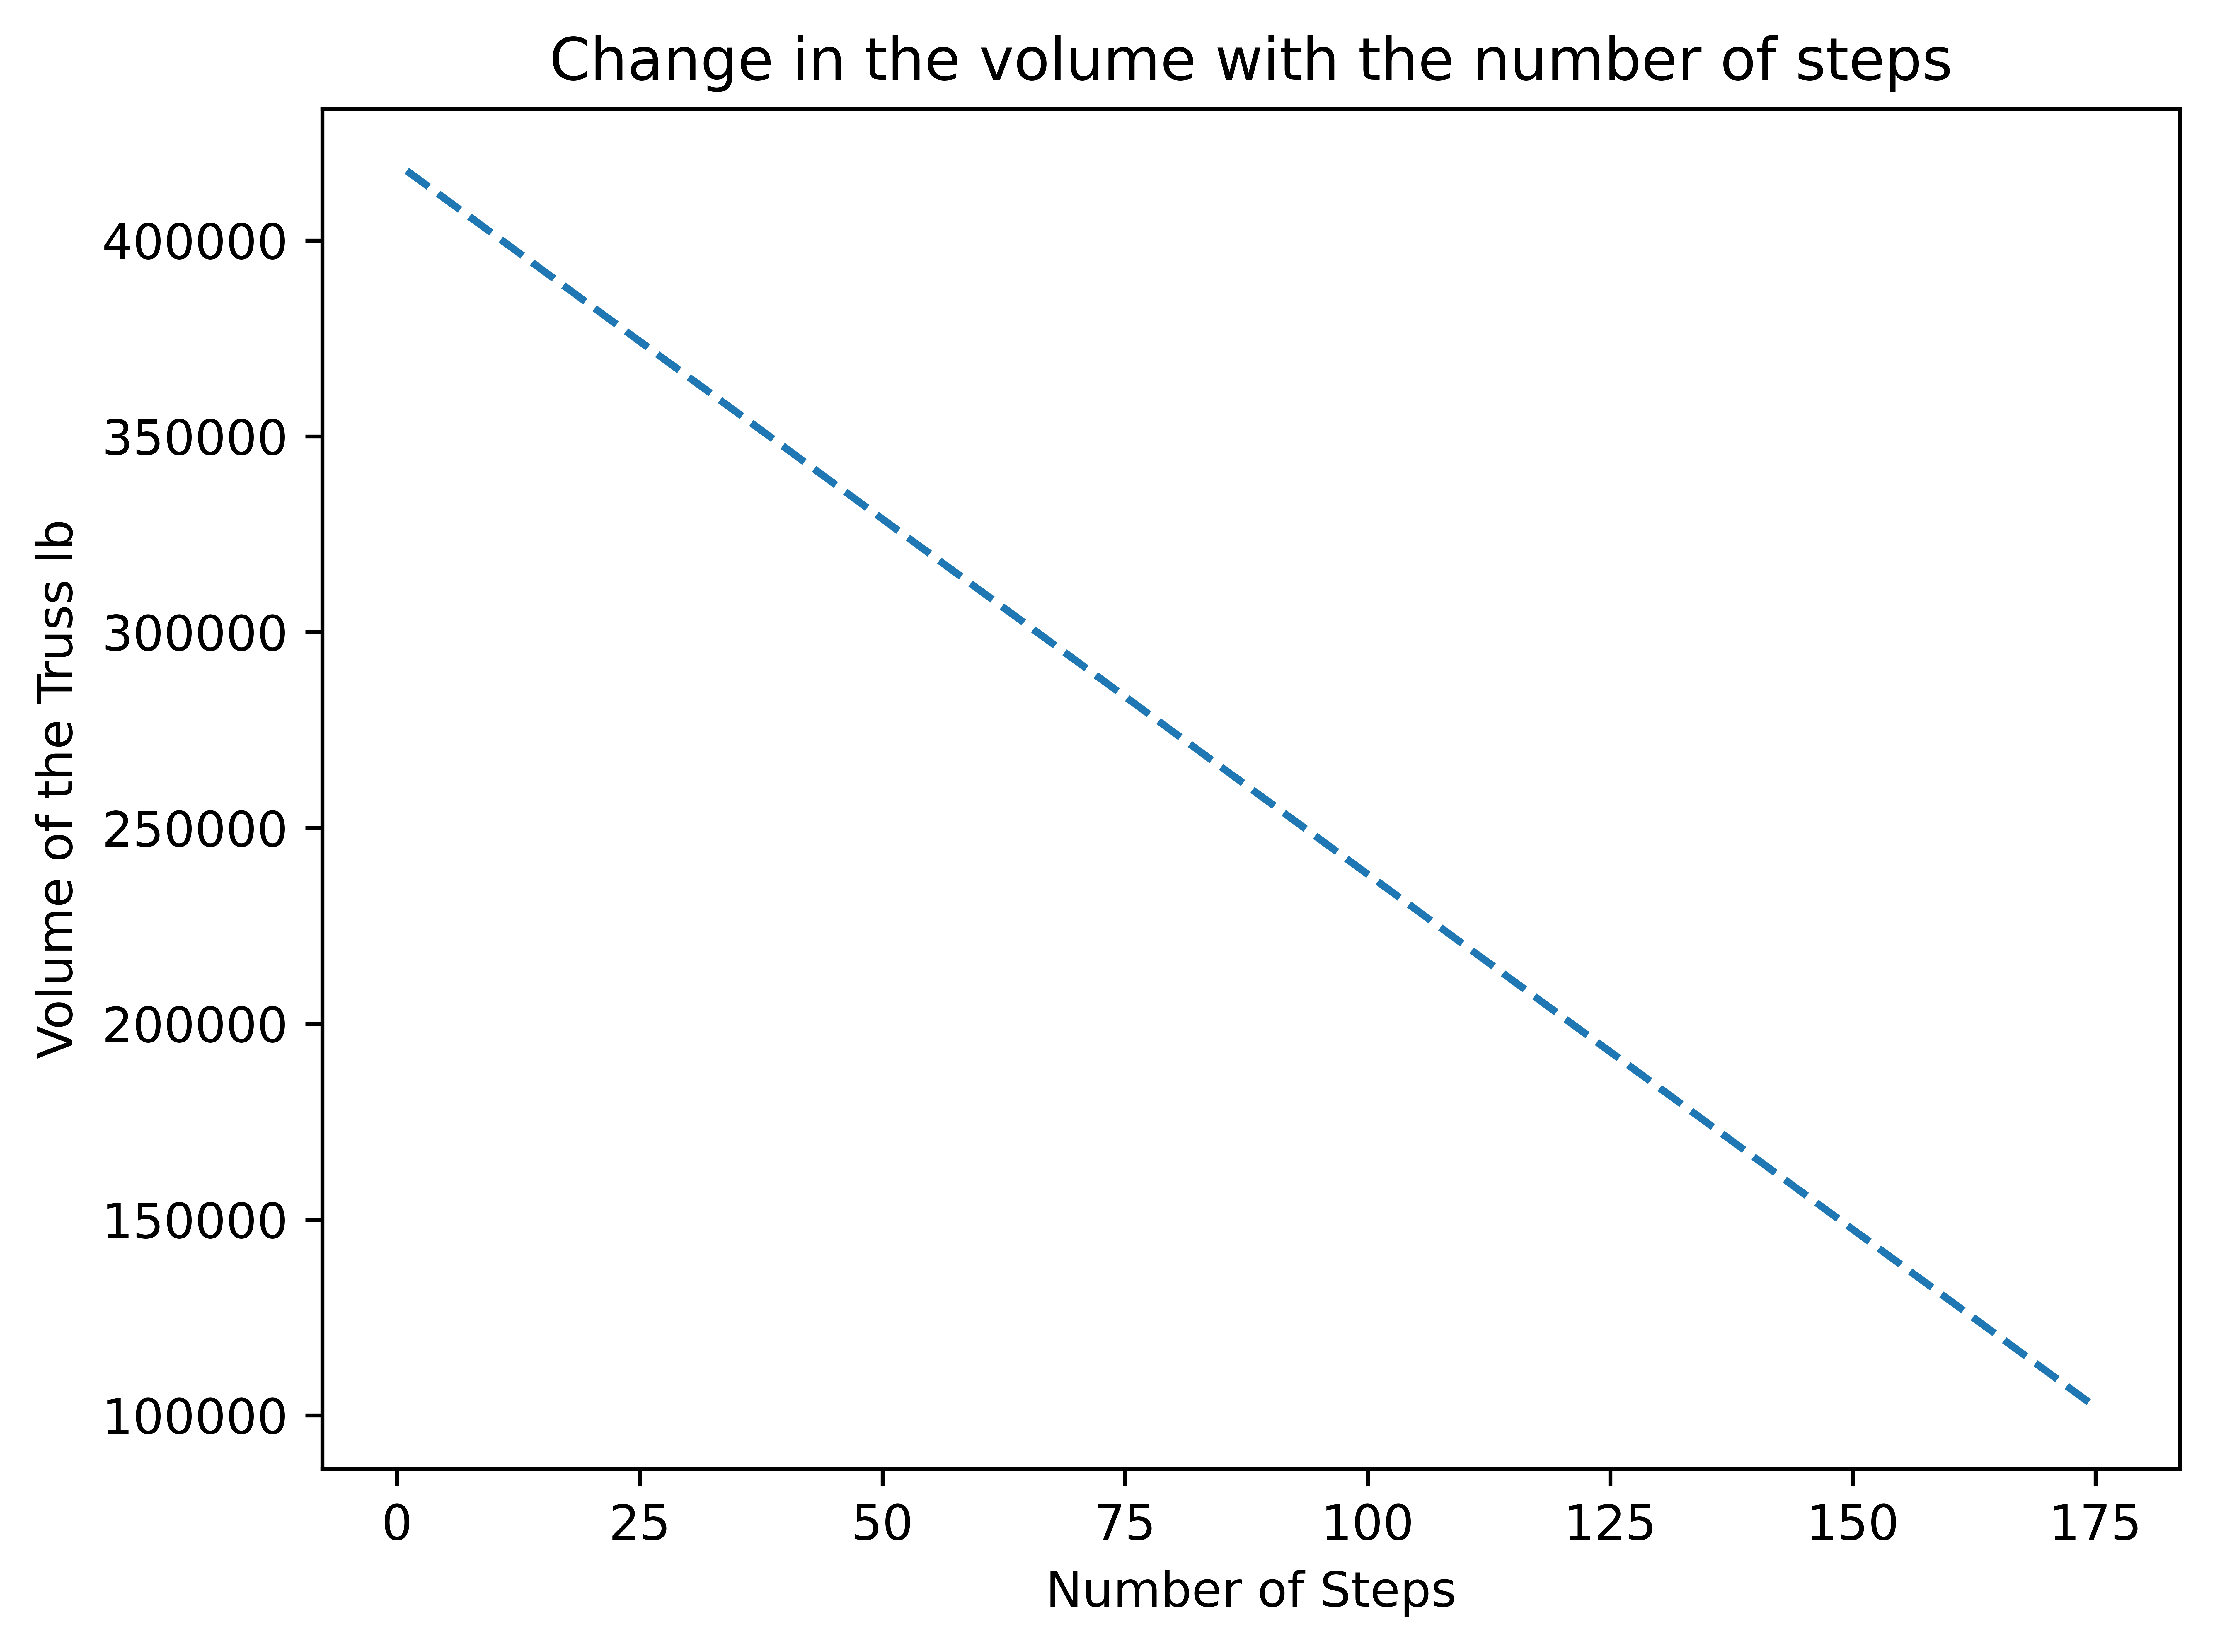

In [24]:
plt.plot(np.linspace(1, len(gd[1]), len(gd[1])), gd[1], "--")
plt.title("Change in the volume with the number of steps")
plt.xlabel("Number of Steps")
plt.ylabel("Volume of the Truss lb")
plt.tight_layout()
plt.show()

In [25]:
soln = Truss.TrussAnalysis(gd[0], nodes, bars)
soln

(array([  5349.65967851,   1237.22965776,  -5461.1511323 ,  -1465.47304494,
          1181.48393087,   1237.22965776,  13236.52606482, -12701.52982628,
          7032.13152314,  -5936.89642242]),
 102126.75298174347,
 array([[ 0.        ,  0.        ],
        [ 0.19258775, -1.1070979 ],
        [ 0.23712802, -2.01081732],
        [ 0.        ,  0.        ],
        [-0.19660144, -1.14963132],
        [-0.24935847, -2.05535758]]),
 'Failed in 0 ways for stress \n Failed in 2 ways for deflection ',
 array([[-300000.        ,  102062.59189504],
        [ 300000.        ,   97937.40810496]]))

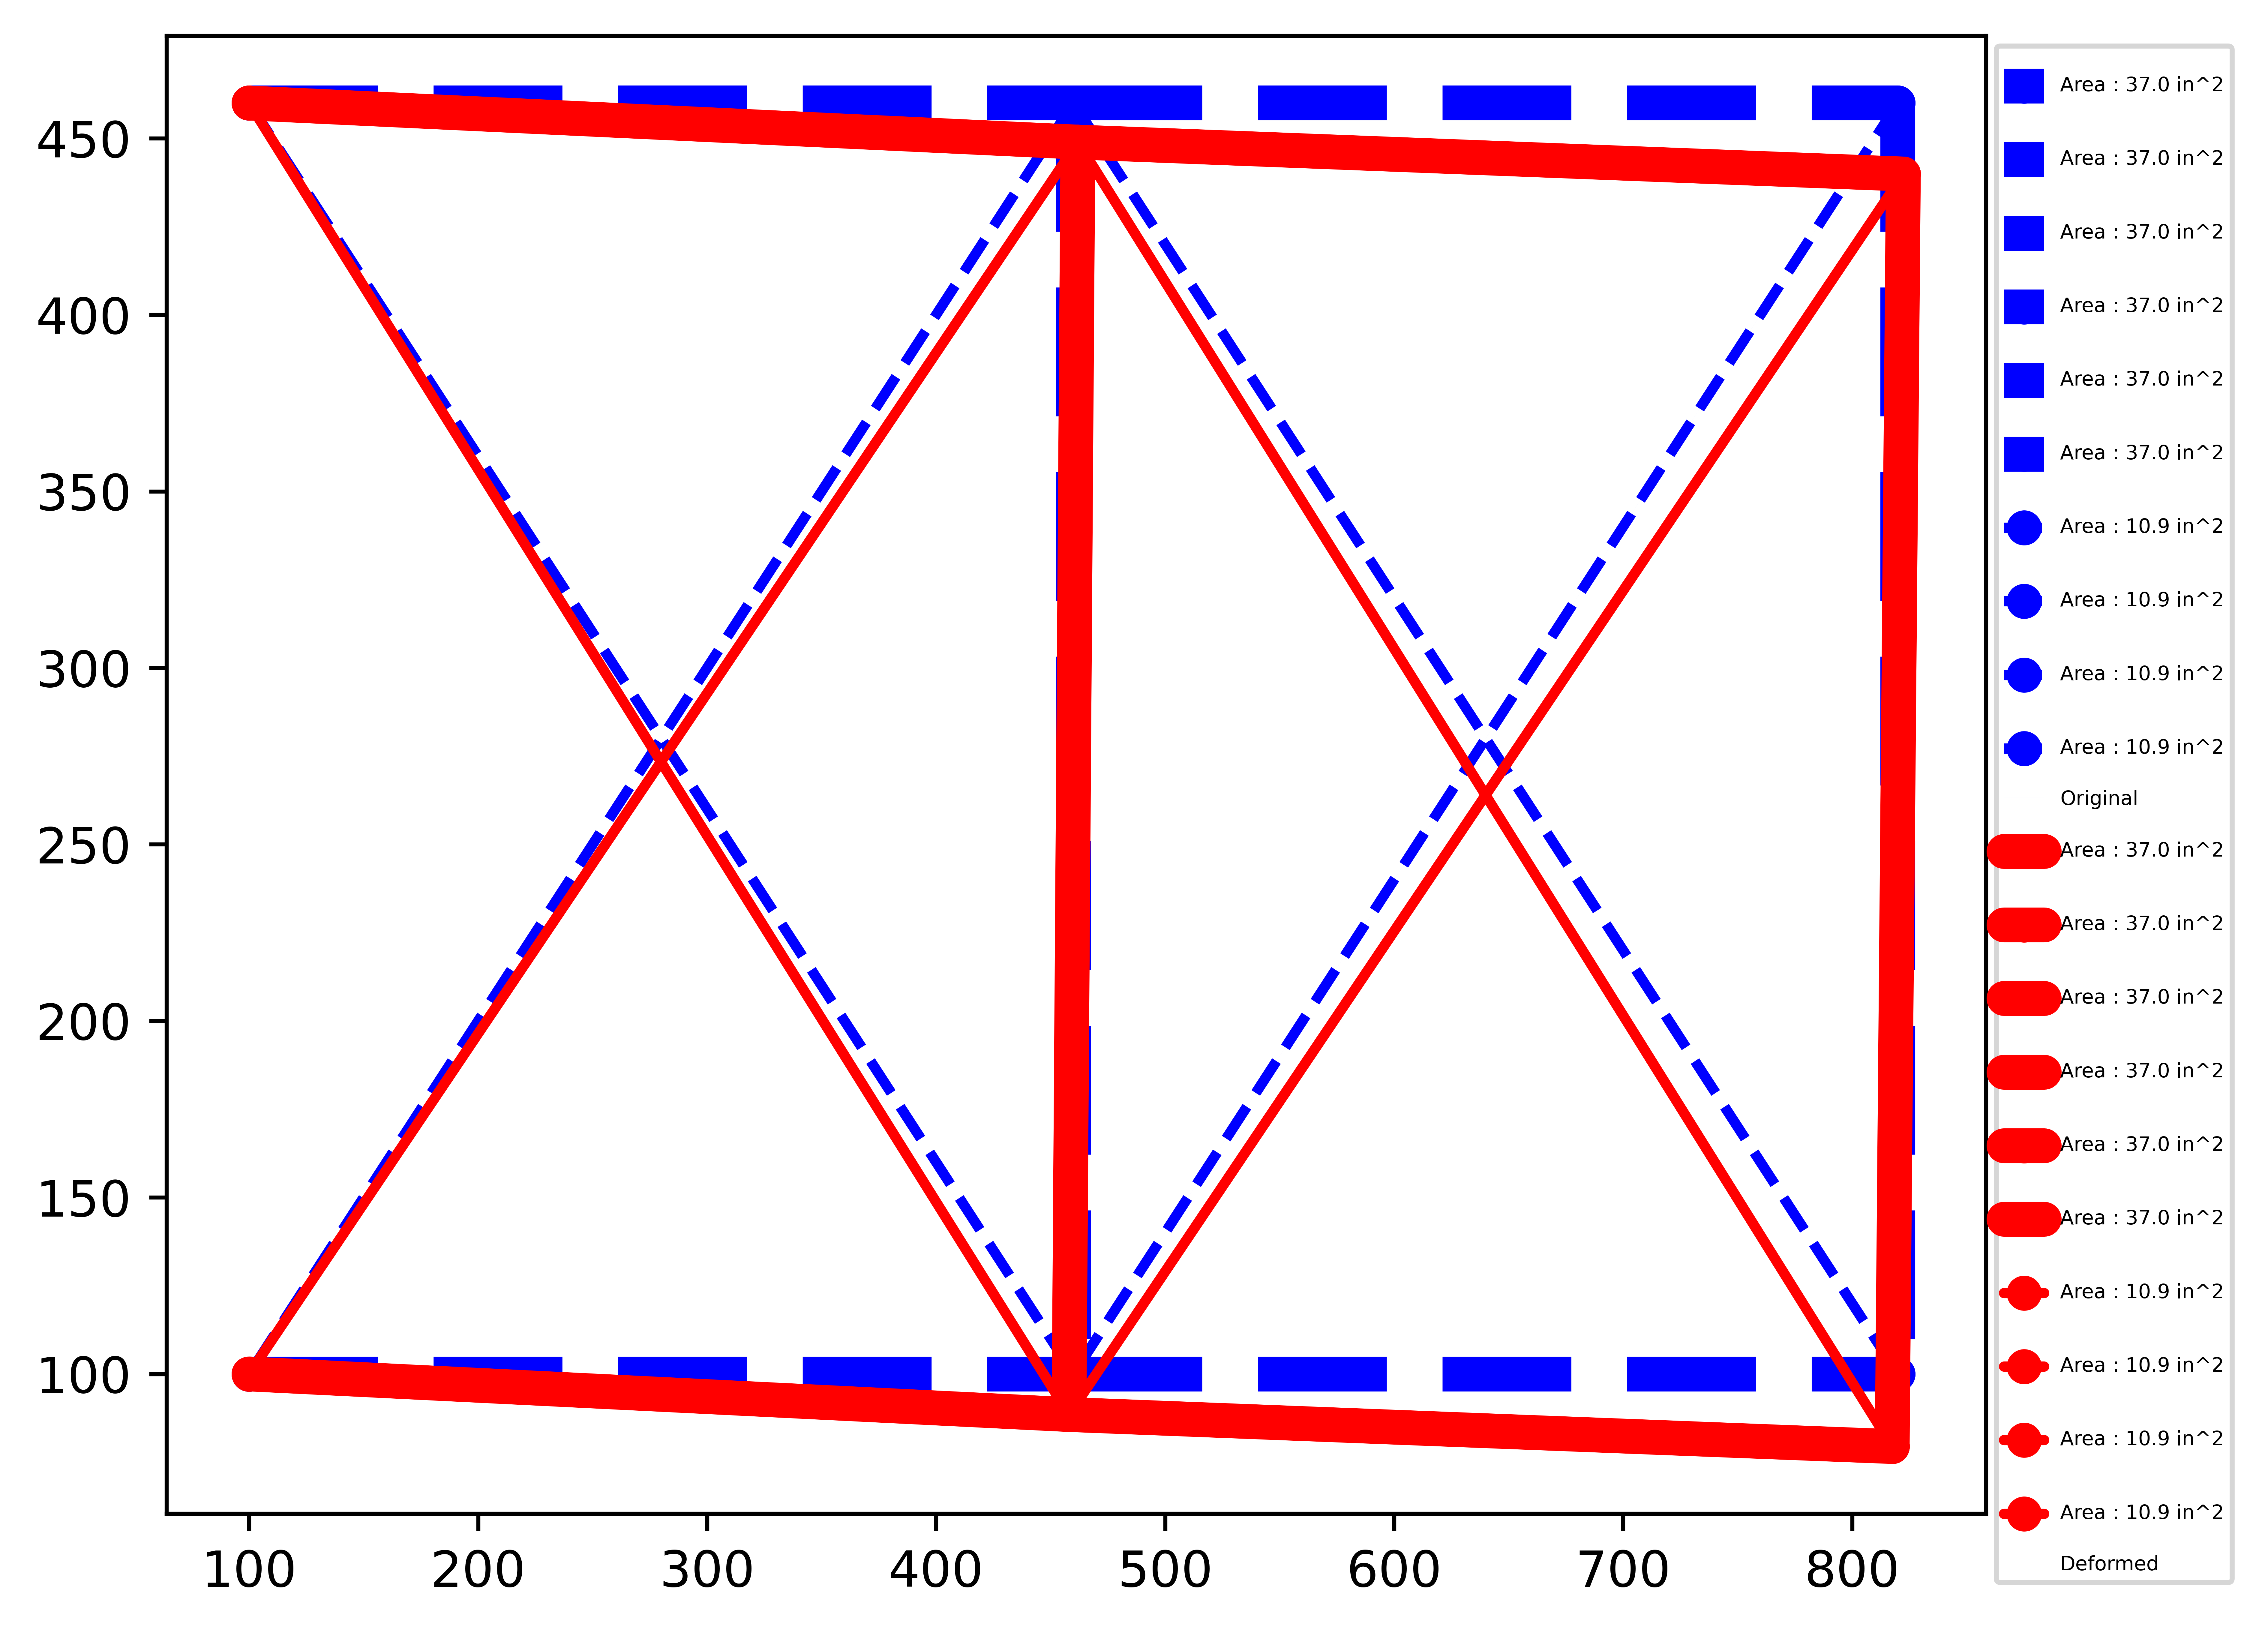

In [26]:
basic.Plot(nodes, 'b', '--',np.round(area,2), 'Original')
scale = 10
Dnodes=  soln[2]*scale + nodes
basic.Plot(Dnodes, 'r', '-',np.round(gd[0],2), 'Deformed')

## Shape (nodal positions)

In [27]:
original_nodes = nodes

In [28]:
def f(nodes):
    # num = np.array([x]*10)
    nodes = nodes.reshape(-1, 2)
    # print(nodes)
    return Truss.TrussAnalysis(x, nodes, bars)[1]

nd.Gradient(f)(nodes).reshape(-1,2)

array([[-34.14213562,  14.14213562],
       [  0.        ,  48.28427125],
       [ 34.14213562,  34.14213562],
       [-34.14213562, -14.14213562],
       [  0.        , -48.28427125],
       [ 34.14213562, -34.14213562]])

In [29]:
area = np.array([30]*10)

In [30]:

def cost(nodes):
    ans = Truss.TrussAnalysis(x, nodes, bars)
    return ans
    

def lr(rate):
    item = []
    for idx in range(6):
        if (idx==1) or (idx==2):
            item.append([rate,rate])
        else:
            item.append([0,0])

    return np.array(item)

def optimize(nodes):
    x = nodes
    learning_rate = 0.001
    max_steps = 10000
    x_new = x
    x_prev = x 

    v = []
    for step in range(max_steps):
     
        if (cost(x)[3]=="Pass"):
            x_prev = x 

            # Compute the gradient
            grad = nd.Gradient(f)(x).reshape(-1,2)
            # grad = clip(grad)
            # print(grad)
            # Update x using gradient descent
           
            x_new -= grad * lr(learning_rate)
            # print(f"x_new : {x}")
            # Compute the current vol
            cost_value = cost(x)[1]
            
            x = x_new
            v.append(cost_value)
            # Print progress
            # if step % 100 == 0:
            #     print("Step: {} Area: {} Volume: {}\n\n".format(step, x, cost_value))
            # else:
            #     pass

            print("Step: {} Nodes: {} Volume: {}\n".format(step, x, cost_value))
        else:
            print("Optimization Saturated")
            return x_prev, v


In [31]:
node_opt = optimize(nodes)

Step: 0 Nodes: [[100.         460.        ]
 [460.         459.95171573]
 [819.96585786 459.96585786]
 [100.         100.        ]
 [460.         100.        ]
 [820.         100.        ]] Volume: 83924.68800314047

Step: 1 Nodes: [[100.         460.        ]
 [460.         459.90343682]
 [819.93171763 459.93171494]
 [100.         100.        ]
 [460.         100.        ]
 [820.         100.        ]] Volume: 83920.02600388364

Step: 2 Nodes: [[100.         460.        ]
 [460.         459.85516328]
 [819.89757928 459.89757124]
 [100.         100.        ]
 [460.         100.        ]
 [820.         100.        ]] Volume: 83915.36459852268

Step: 3 Nodes: [[100.         460.        ]
 [460.         459.8068951 ]
 [819.86344284 459.86342675]
 [100.         100.        ]
 [460.         100.        ]
 [820.         100.        ]] Volume: 83910.70378700558

Step: 4 Nodes: [[100.         460.        ]
 [460.         459.75863229]
 [819.82930829 459.82928147]
 [100.         100.        ]
 

In [32]:
print(f" The new nodal positions after optimization are :\n {node_opt[0]}")

 The new nodal positions after optimization are :
 [[100.         460.        ]
 [460.07676747 407.20491137]
 [781.50681321 419.74276853]
 [100.         100.        ]
 [460.         100.        ]
 [820.         100.        ]]


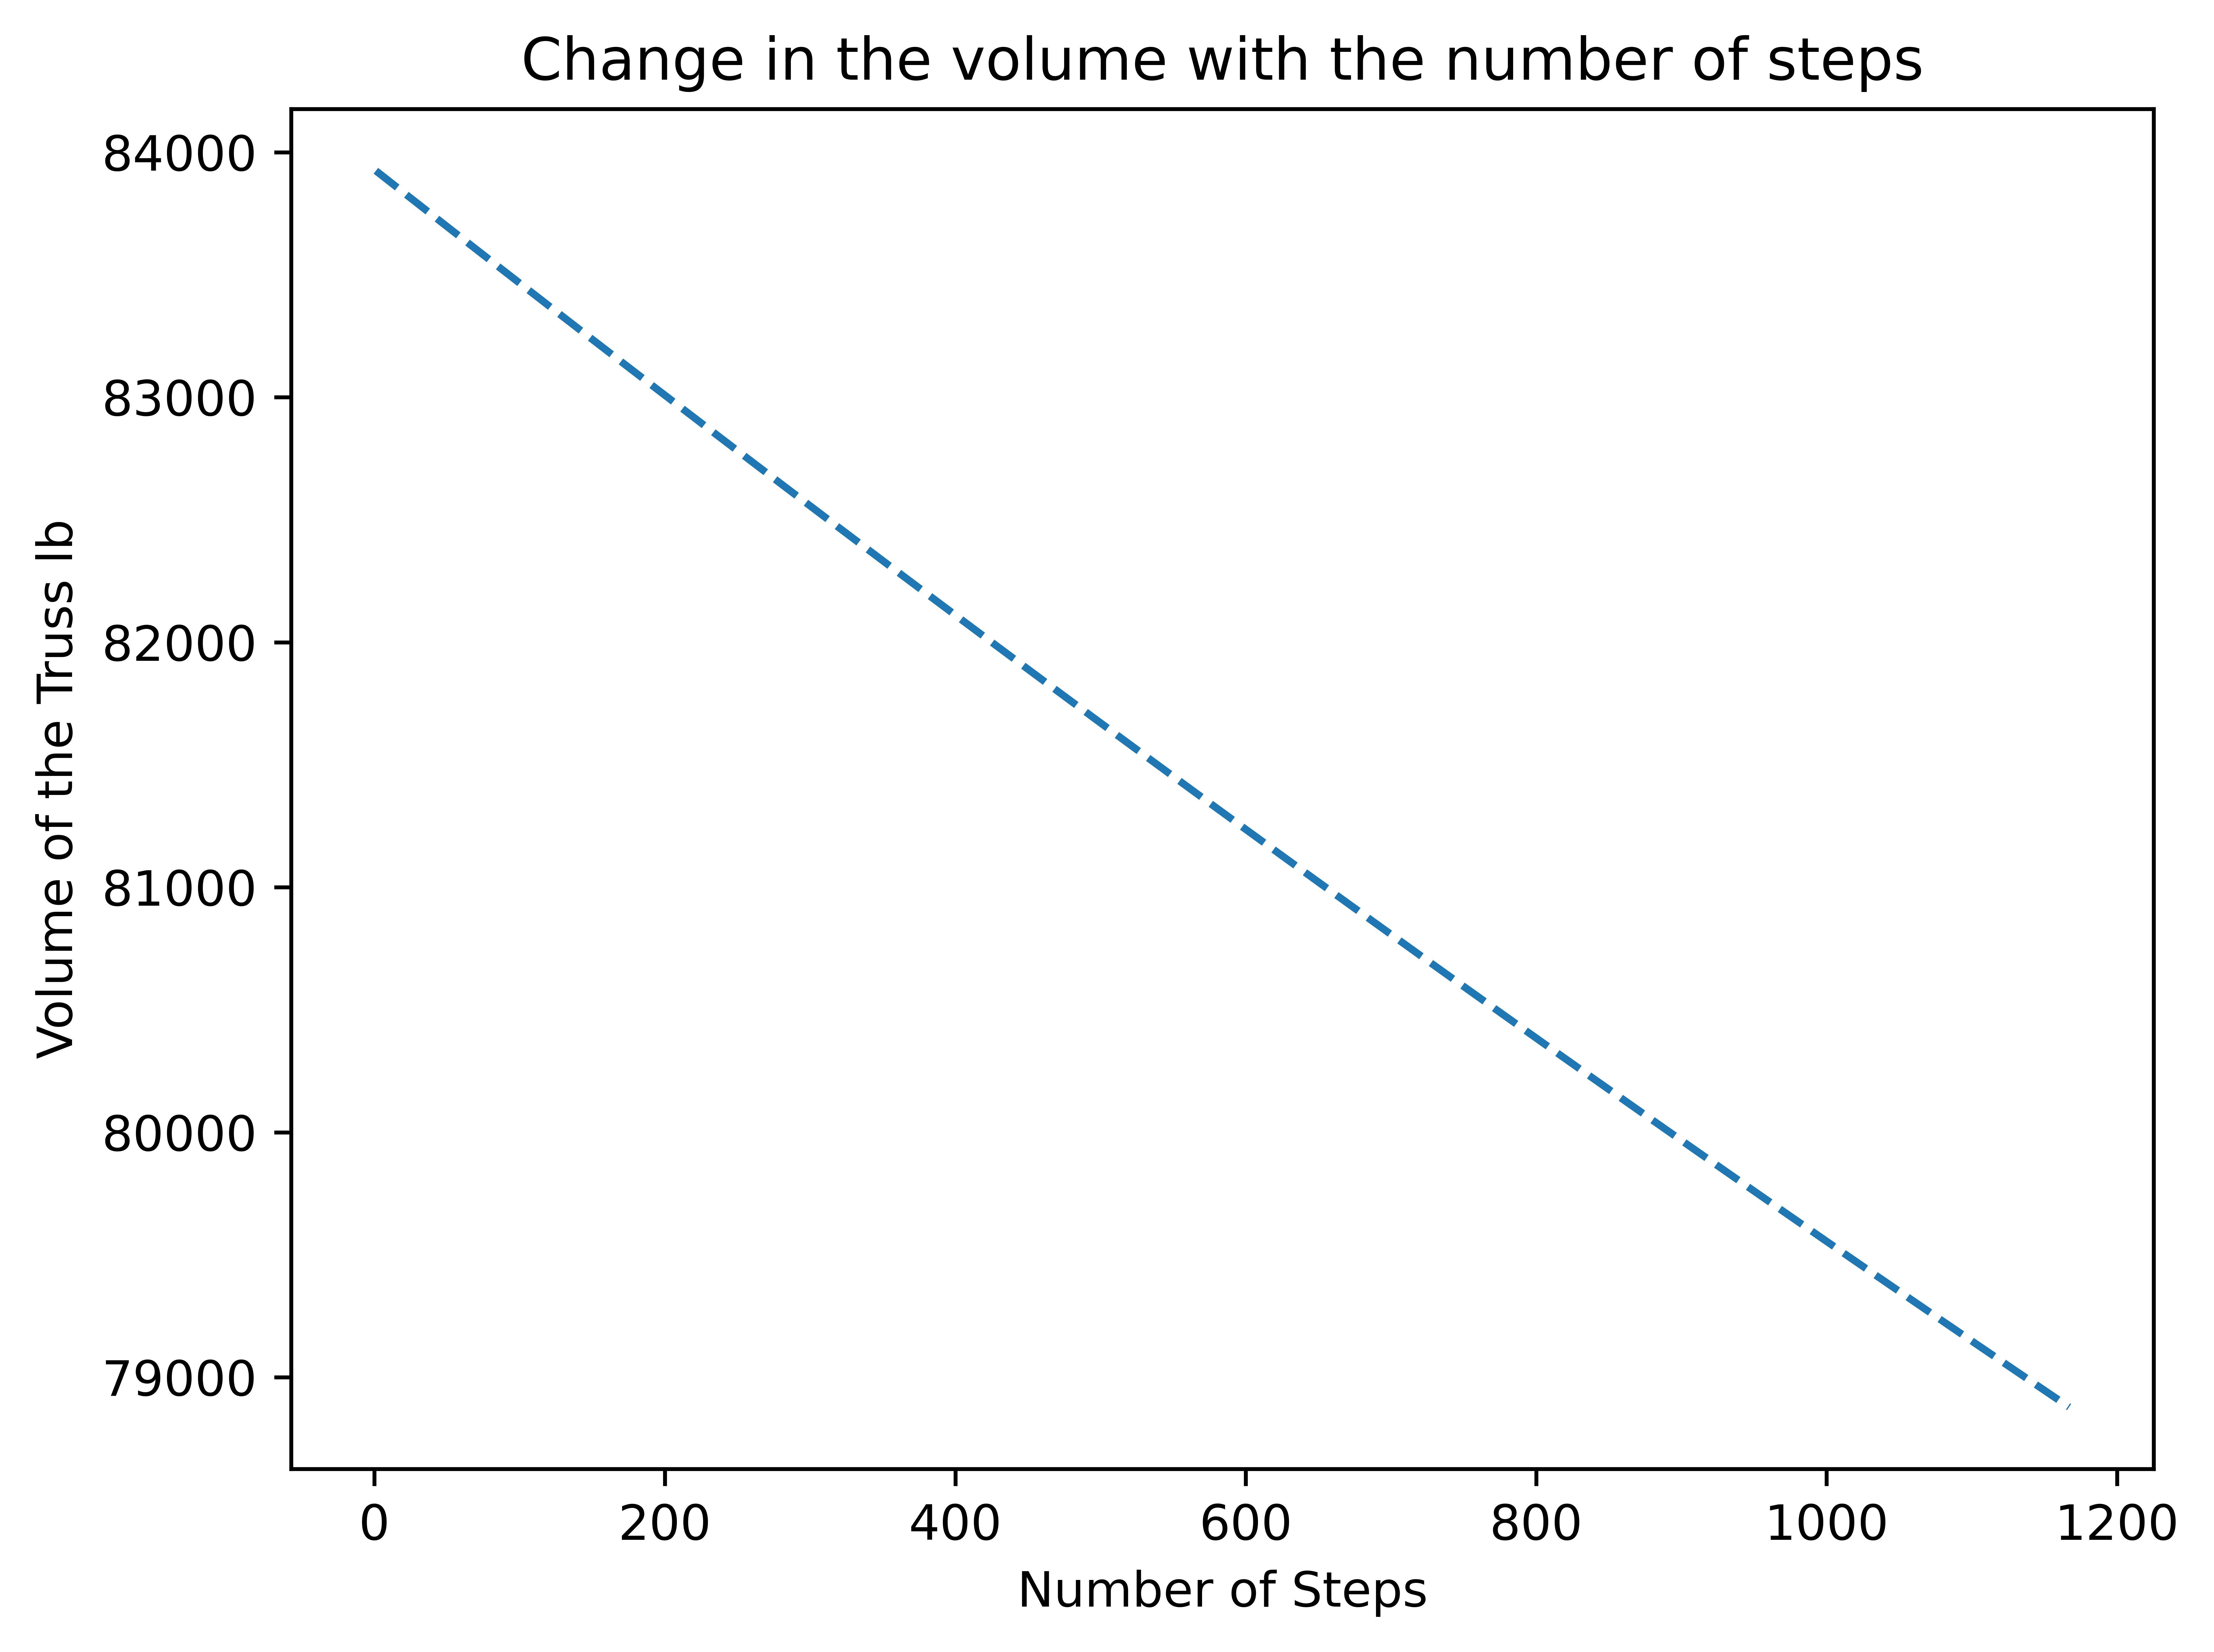

In [33]:
plt.plot(np.linspace(1, len(node_opt[1]), len(node_opt[1])), node_opt[1], "--")
plt.title("Change in the volume with the number of steps")
plt.xlabel("Number of Steps")
plt.ylabel("Volume of the Truss lb")
plt.tight_layout()
plt.show()

In [34]:
# area = np.array([1]*10)

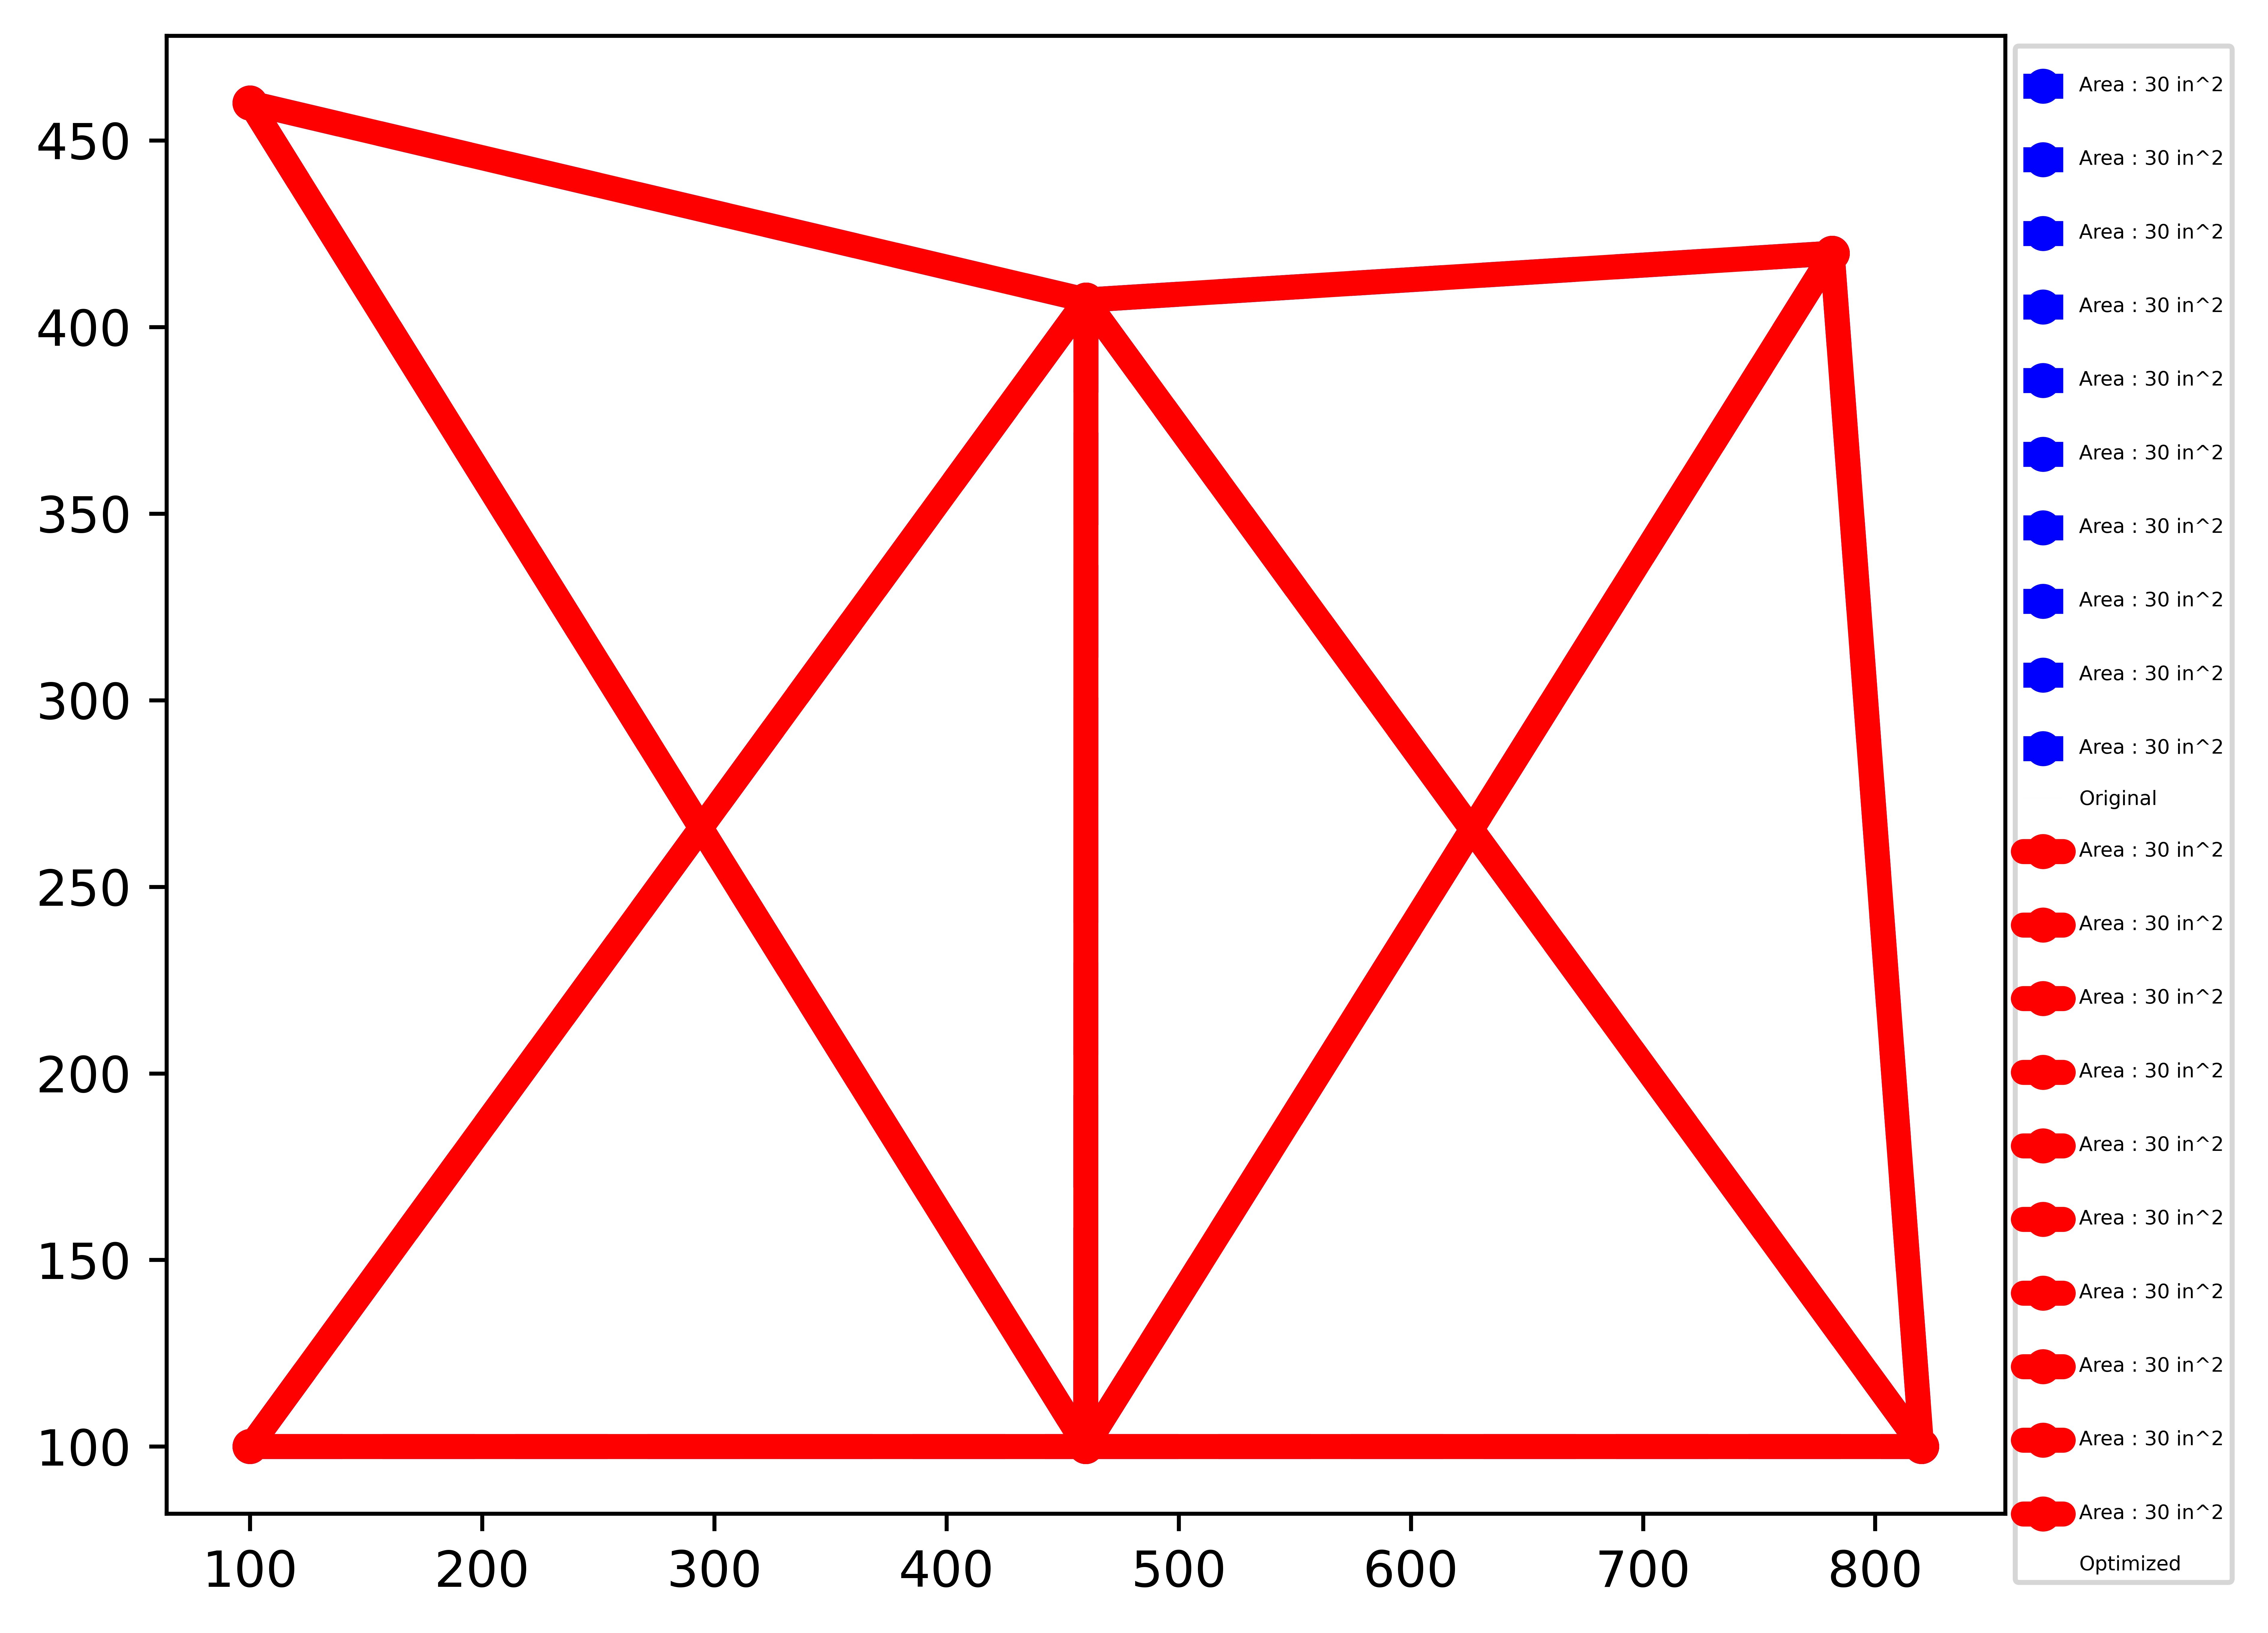

In [35]:
basic.Plot(original_nodes, 'b', '--', np.round(area,2), 'Original')
# scale = 10
# Dnodes=  soln[2]*scale + nodes
basic.Plot(node_opt[0], 'r', '-', np.round(area,2), 'Optimized')

In [64]:
Truss.TrussAnalysis(area, node_opt[0], bars)

(array([ 7022.13228166,  1660.69846607, -6957.43711651, -2416.76486031,
         1761.97071799,  1426.28609988,  4316.39588143, -3999.42616139,
         2953.25957278, -2099.93822786]),
 118317.8312148003,
 array([[ 0.        ,  0.        ],
        [ 0.18391575, -0.50722818],
        [ 0.26496725, -1.21455786],
        [ 0.        ,  0.        ],
        [-0.25046774, -0.56124824],
        [-0.33747127, -1.33334964]]),
 'Pass',
 array([[-300000.        ,  122125.75105734],
        [ 300000.        ,   77874.24894266]]))

In [36]:
a = [11.5]*10 #area_gen(area_avalival)

In [37]:
# a = [7.22,3.13,14.2,3.63,5.74,1.62,11.5,3.13,3.63,3.87]

In [38]:
# a = [31.82, 1, 23.74, 15.32, 1, 1, 8.67, 22.09, 21.70, 1]

In [39]:
a = np.array(a)

In [40]:
a

array([11.5, 11.5, 11.5, 11.5, 11.5, 11.5, 11.5, 11.5, 11.5, 11.5])

In [41]:
sum(a)

115.0

In [42]:
# le = [360.   ,      360.    ,     360.       ,  360.   ,      360.,
#  360.  ,       509.11688245 ,509.11688245 ,509.11688245 ,509.11688245]

In [43]:
# v = []
# for i, b in zip(a,le):
#     print(i,b)
#     v.append(i*b)

In [44]:
# v

In [45]:
# sum(v)

In [46]:
# 57368/8083


In [47]:
a_temp = Truss.TrussAnalysis(a, nodes, bars)

In [48]:
a_temp

(array([ 18318.60595216,   4332.25686802, -18149.83595612,  -6304.60398343,
          4596.44535128,   3720.7463475 ,  11260.16316895, -10433.28563841,
          7704.15540724,  -5478.09972485]),
 45355.16863234012,
 array([[ 0.        ,  0.        ],
        [ 0.47978022, -1.32320394],
        [ 0.69121892, -3.1684118 ],
        [ 0.        ,  0.        ],
        [-0.65339409, -1.46412584],
        [-0.88035984, -3.4783034 ]]),
 'Failed in 0 ways for stress \n Failed in 2 ways for deflection ',
 array([[-300000.        ,  122125.75105734],
        [ 300000.        ,   77874.24894266]]))

In [49]:
print(f""" 
The Stress in the various members of the truss is \x1B[3mpsi\x1B[0m : \n{a_temp[0]}\n\n 
The Volume of the the truss is \x1B[3m inch^3 \x1B[0m : {a_temp[1]}\n
The nodal displacements [x & y] in \x1B[3minch\x1B[0m : \n{a_temp[2]}\n\n 
Results for check for stress and deflection limit : {a_temp[3]}\n
The reaction of the supports [x & y] in \x1B[3mpsi\x1B[0m : \n{a_temp[4]} """)

 
The Stress in the various members of the truss is psi : 
[ 18318.60595216   4332.25686802 -18149.83595612  -6304.60398343
   4596.44535128   3720.7463475   11260.16316895 -10433.28563841
   7704.15540724  -5478.09972485]

 
The Volume of the the truss is  inch^3  : 45355.16863234012

The nodal displacements [x & y] in inch : 
[[ 0.          0.        ]
 [ 0.47978022 -1.32320394]
 [ 0.69121892 -3.1684118 ]
 [ 0.          0.        ]
 [-0.65339409 -1.46412584]
 [-0.88035984 -3.4783034 ]]

 
Results for check for stress and deflection limit : Failed in 0 ways for stress 
 Failed in 2 ways for deflection 

The reaction of the supports [x & y] in psi : 
[[-300000.          122125.75105734]
 [ 300000.           77874.24894266]] 


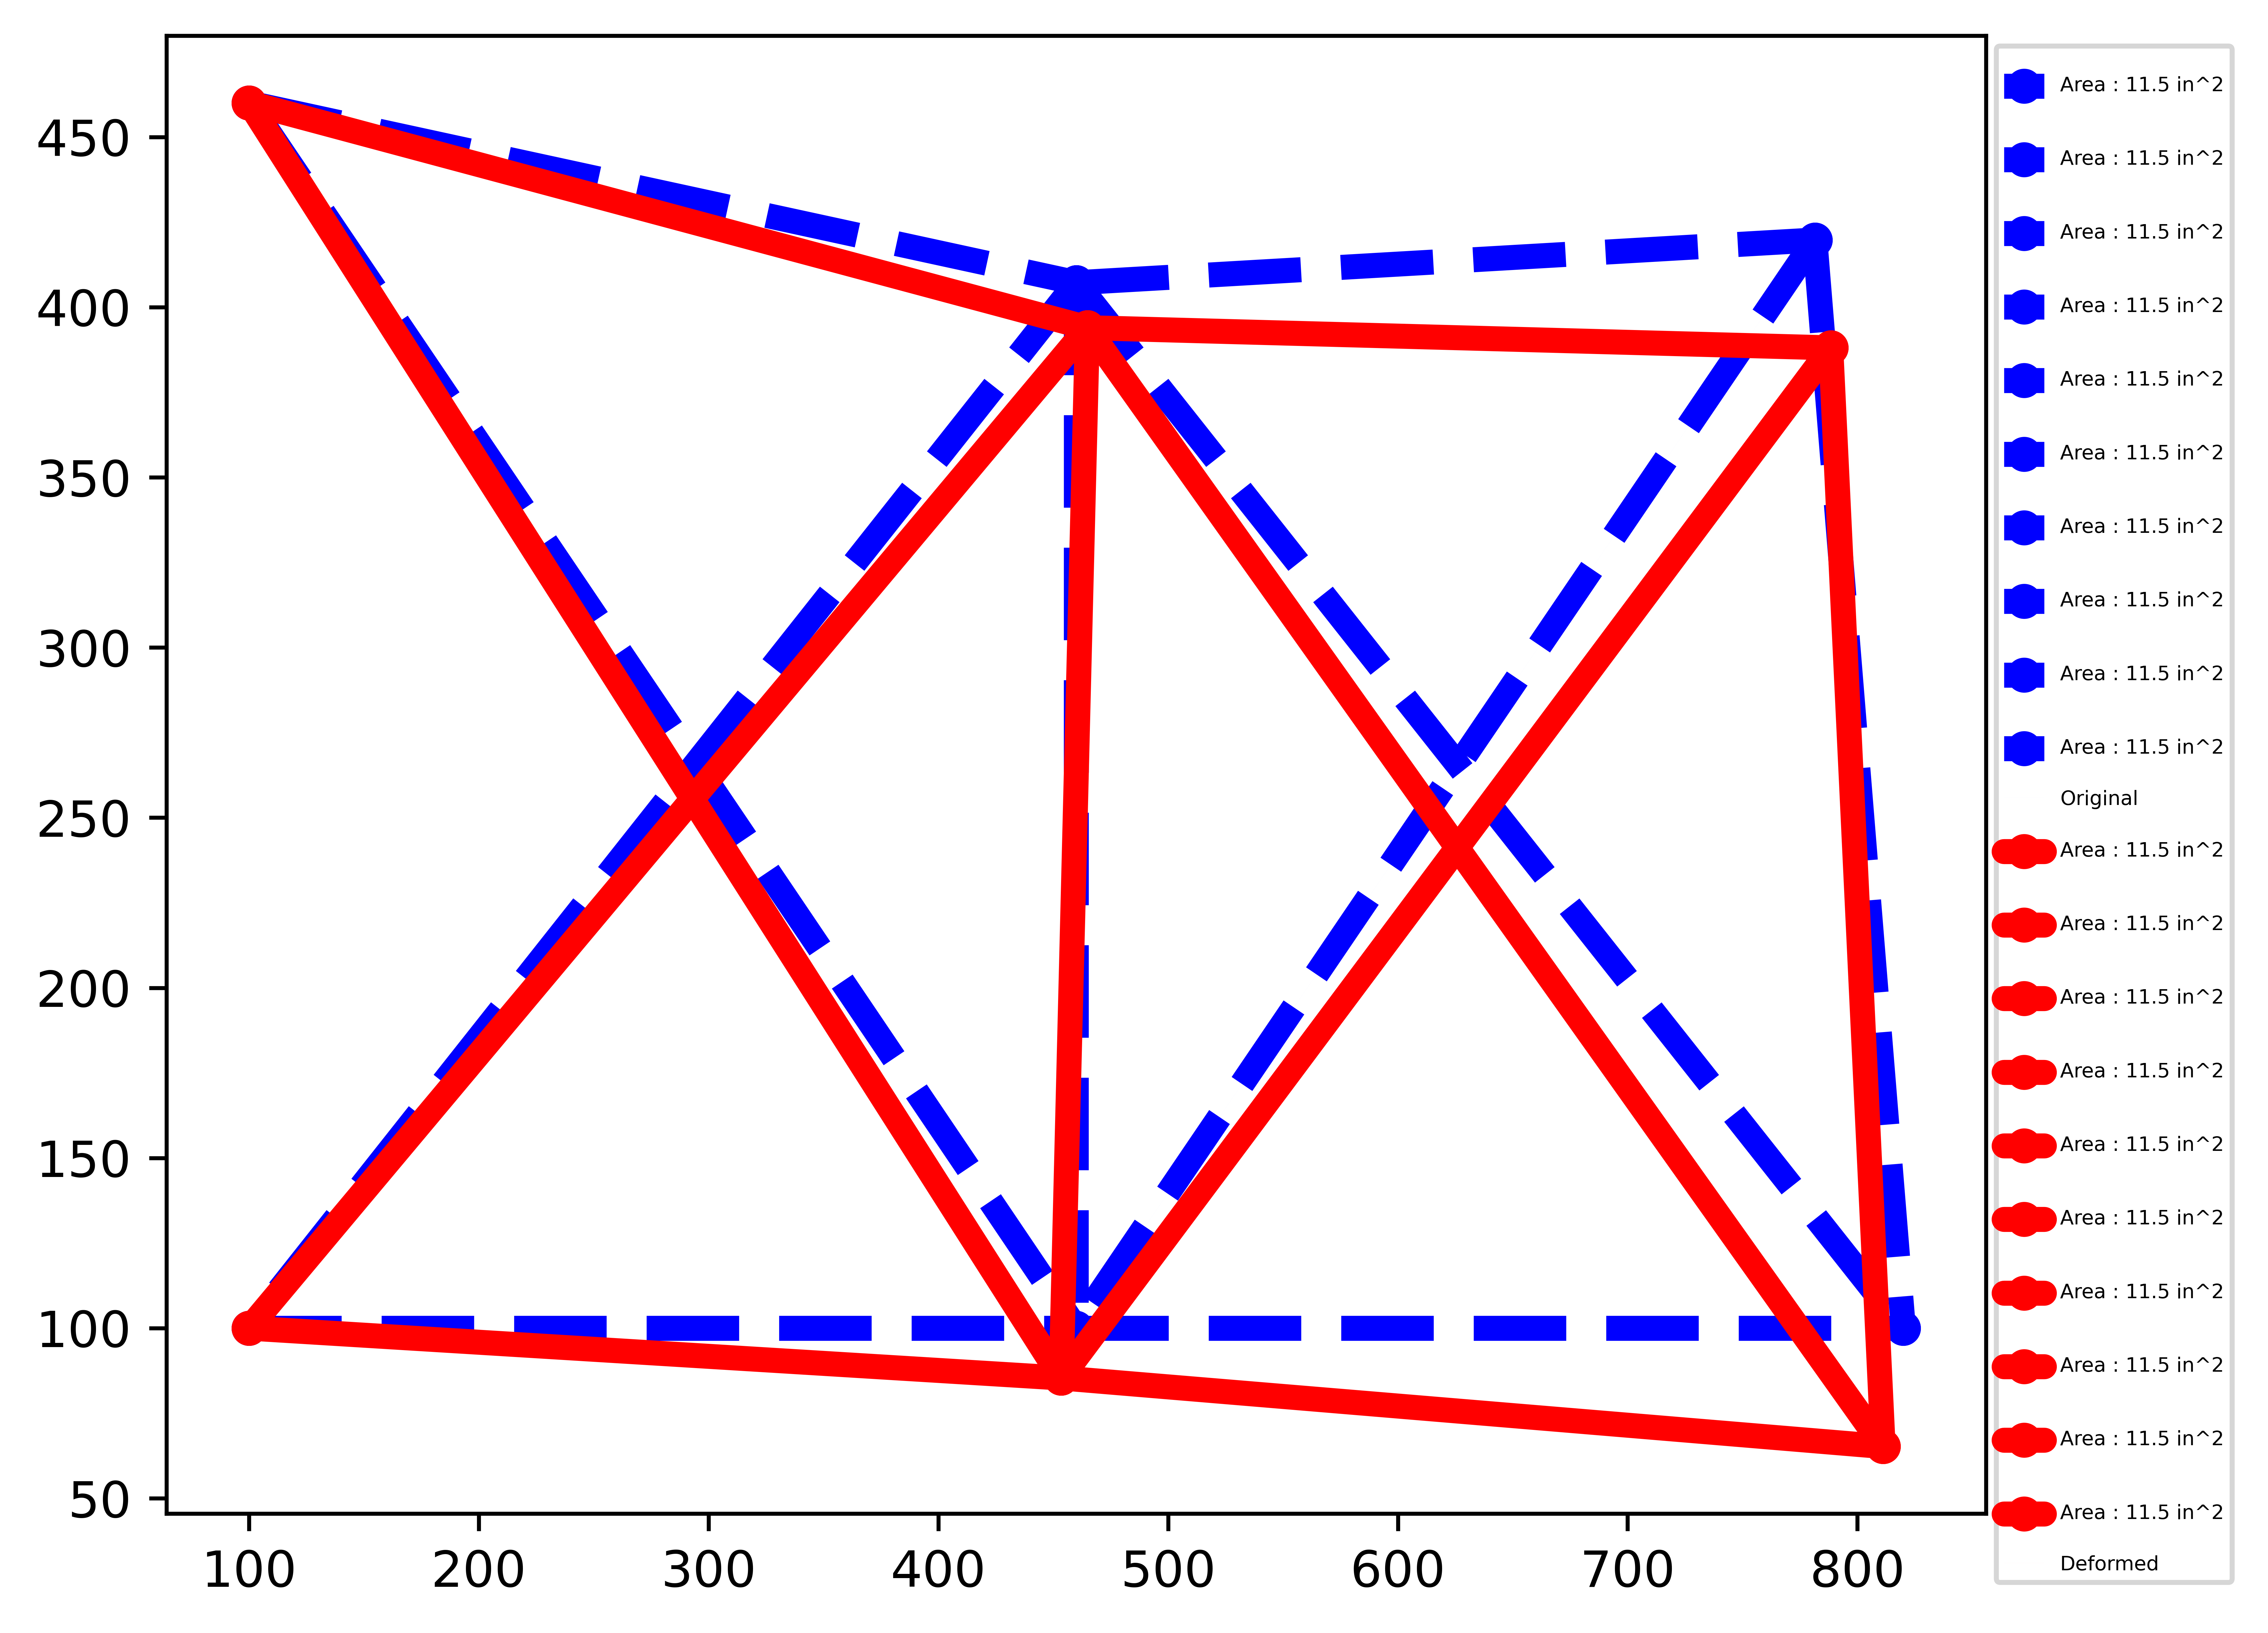

In [50]:
basic.Plot(nodes, 'b', '--',a, 'Original')
scale = 10
Dnodes=  a_temp[2]*scale + nodes
basic.Plot(Dnodes, 'r', '-',a, 'Deformed')

In [51]:
# defining the algorithm

def initialize(dim):
    '''Function that initilizes the bias and weights'''

    b = np.random.rand(dim)
    theta= np.random.rand(dim)
    return b,theta

b, theta = initialize(len(bars))
print(f"Bias : {b}, \nWeights : {theta}")

Bias : [0.29624916 0.80906772 0.35025253 0.78940926 0.56134898 0.25358895
 0.10497708 0.05846073 0.67329238 0.69782966], 
Weights : [0.73278321 0.78787406 0.07637632 0.3176806  0.74102328 0.32849423
 0.47014548 0.18108572 0.3235044  0.45490616]


In [52]:
def predict_Y(b, theta, area):

    pred = []
    if len(b) != len(theta):
        return print(f"The leangth of the weights and areas' are inconsistant")
    else:
        for i in range(len(area)):
            pred.append(b[i] + np.dot(area[i], theta[i]))
        return np.round(np.array(pred),2)

Y_hat = predict_Y(b,theta,a)
Y_hat

array([8.72, 9.87, 1.23, 4.44, 9.08, 4.03, 5.51, 2.14, 4.39, 5.93])

In [53]:
Truss.TrussAnalysis(Y_hat, nodes, bars)

(array([  28141.85000316,    5980.89952261, -141747.14809304,
         -14470.0375482 ,   10510.72442524,   12580.40081847,
          14680.88431185,  -77180.98613658,   17426.04688736,
         -12587.65121841]),
 21061.206418161393,
 array([[  0.        ,   0.        ],
        [  0.17907839,  -5.83834628],
        [  0.64101695, -12.74494026],
        [  0.        ,   0.        ],
        [ -5.10289733,  -6.159921  ],
        [ -5.62381868, -13.90723031]]),
 'Failed in 3 ways for stress \n Failed in 4 ways for deflection ',
 array([[-300000.        ,   92798.95229153],
        [ 300000.        ,  107201.04770847]]))

In [54]:
def get_cost(Area, Nodes, Bar):
    ans = Truss.TrussAnalysis(Area, Nodes, Bar)
    
    loss = np.abs(ans[1]) #np.abs(ans[0]).sum()*0.0001 + np.abs(ans[1]) + np.abs(ans[2]).sum()
    # print(ans)
    #sum = ans.sum(axis=1)
    if ans[3]=='Pass':
        if loss == 0 :
            return 99999
        else:
            return abs(1/loss)
    else:
        return -1/loss #"Unstable solution"

get_cost(Y_hat, nodes, bars)

-4.748066089593448e-05

In [55]:
def update_theta(area, y_hat, b_0, theta_o, learning_rate):
    db = (np.sum(area-y_hat)*2)/len(y_hat)
    dw = (np.dot((area-y_hat),area)*2)/len(y_hat)

    b_1 = b_0 - learning_rate*db
    theta_1 = theta_o - learning_rate*dw
    return b_1, theta_1
    
print("After initialization -Bias: ",b,"theta: ",theta)
Y_hat = predict_Y(b,theta,a)
b,theta = update_theta(a, Y_hat, b,theta, 0.01)
print("After first update -Bias: ",b,"theta: ",theta)
get_cost(Y_hat, nodes, bars)

After initialization -Bias:  [0.29624916 0.80906772 0.35025253 0.78940926 0.56134898 0.25358895
 0.10497708 0.05846073 0.67329238 0.69782966] theta:  [0.73278321 0.78787406 0.07637632 0.3176806  0.74102328 0.32849423
 0.47014548 0.18108572 0.3235044  0.45490616]
After first update -Bias:  [ 0.17692916  0.68974772  0.23093253  0.67008926  0.44202898  0.13426895
 -0.01434292 -0.06085927  0.55397238  0.57850966] theta:  [-0.63939679 -0.58430594 -1.29580368 -1.0544994  -0.63115672 -1.04368577
 -0.90203452 -1.19109428 -1.0486756  -0.91727384]


-4.748066089593448e-05

In [56]:
def run_gradient_descent(X, alpha, num_iterations):

    ''' X: area,
        alpha : learning rate
        num_iter : no of iterations
    '''

    b, theta = initialize(X.shape[0])
    iter_num=0
    gd_iterations_df = pd.DataFrame(columns=['iteration','cost'])
    result_idx=0

    for each_iter in range(num_iterations):
        # print(iter_num)
        Y_hat = predict_Y(b,theta,X)
        this_cost = get_cost(Y_hat, nodes, bars)
        prev_b = b
        prev_theta = theta
        b, theta = update_theta(a, Y_hat, b,theta,alpha)
        iter_num += 1
        if(iter_num%10==0):
            gd_iterations_df.loc[result_idx]=[iter_num,this_cost]
            result_idx=result_idx+1
            iter_num += 1

    print('Final Estimate of b and theta : ',b,theta)
    return gd_iterations_df,b,theta

gd_iterations_df,b,theta = run_gradient_descent(a, alpha=0.001,num_iterations=200)

Final Estimate of b and theta :  [-1.40706409e+19 -1.40706409e+19 -1.40706409e+19 -1.40706409e+19
 -1.40706409e+19 -1.40706409e+19 -1.40706409e+19 -1.40706409e+19
 -1.40706409e+19 -1.40706409e+19] [-1.6181237e+20 -1.6181237e+20 -1.6181237e+20 -1.6181237e+20
 -1.6181237e+20 -1.6181237e+20 -1.6181237e+20 -1.6181237e+20
 -1.6181237e+20 -1.6181237e+20]


In [57]:
gd_iterations_df

iteration          cost
0        10.0  7.041256e-06
1        20.0  6.574019e-07
2        30.0  7.643138e-08
3        40.0  9.089049e-09
4        50.0  1.083718e-09
5        60.0  1.292560e-10
6        70.0  1.541707e-11
7        80.0  1.838886e-12
8        90.0  2.193351e-13
9       100.0  2.616142e-14
10      110.0  3.120431e-15
11      120.0  3.721927e-16
12      130.0  4.439367e-17
13      140.0  5.295102e-18
14      150.0  6.315788e-19
15      160.0  7.533223e-20
16      170.0  8.985331e-21
17      180.0  1.071735e-21
18      190.0  1.278323e-22
19      200.0  1.524733e-23
20      210.0  1.818641e-24
21      220.0  2.169204e-25

Text(0, 0.5, 'Cost or MSE')

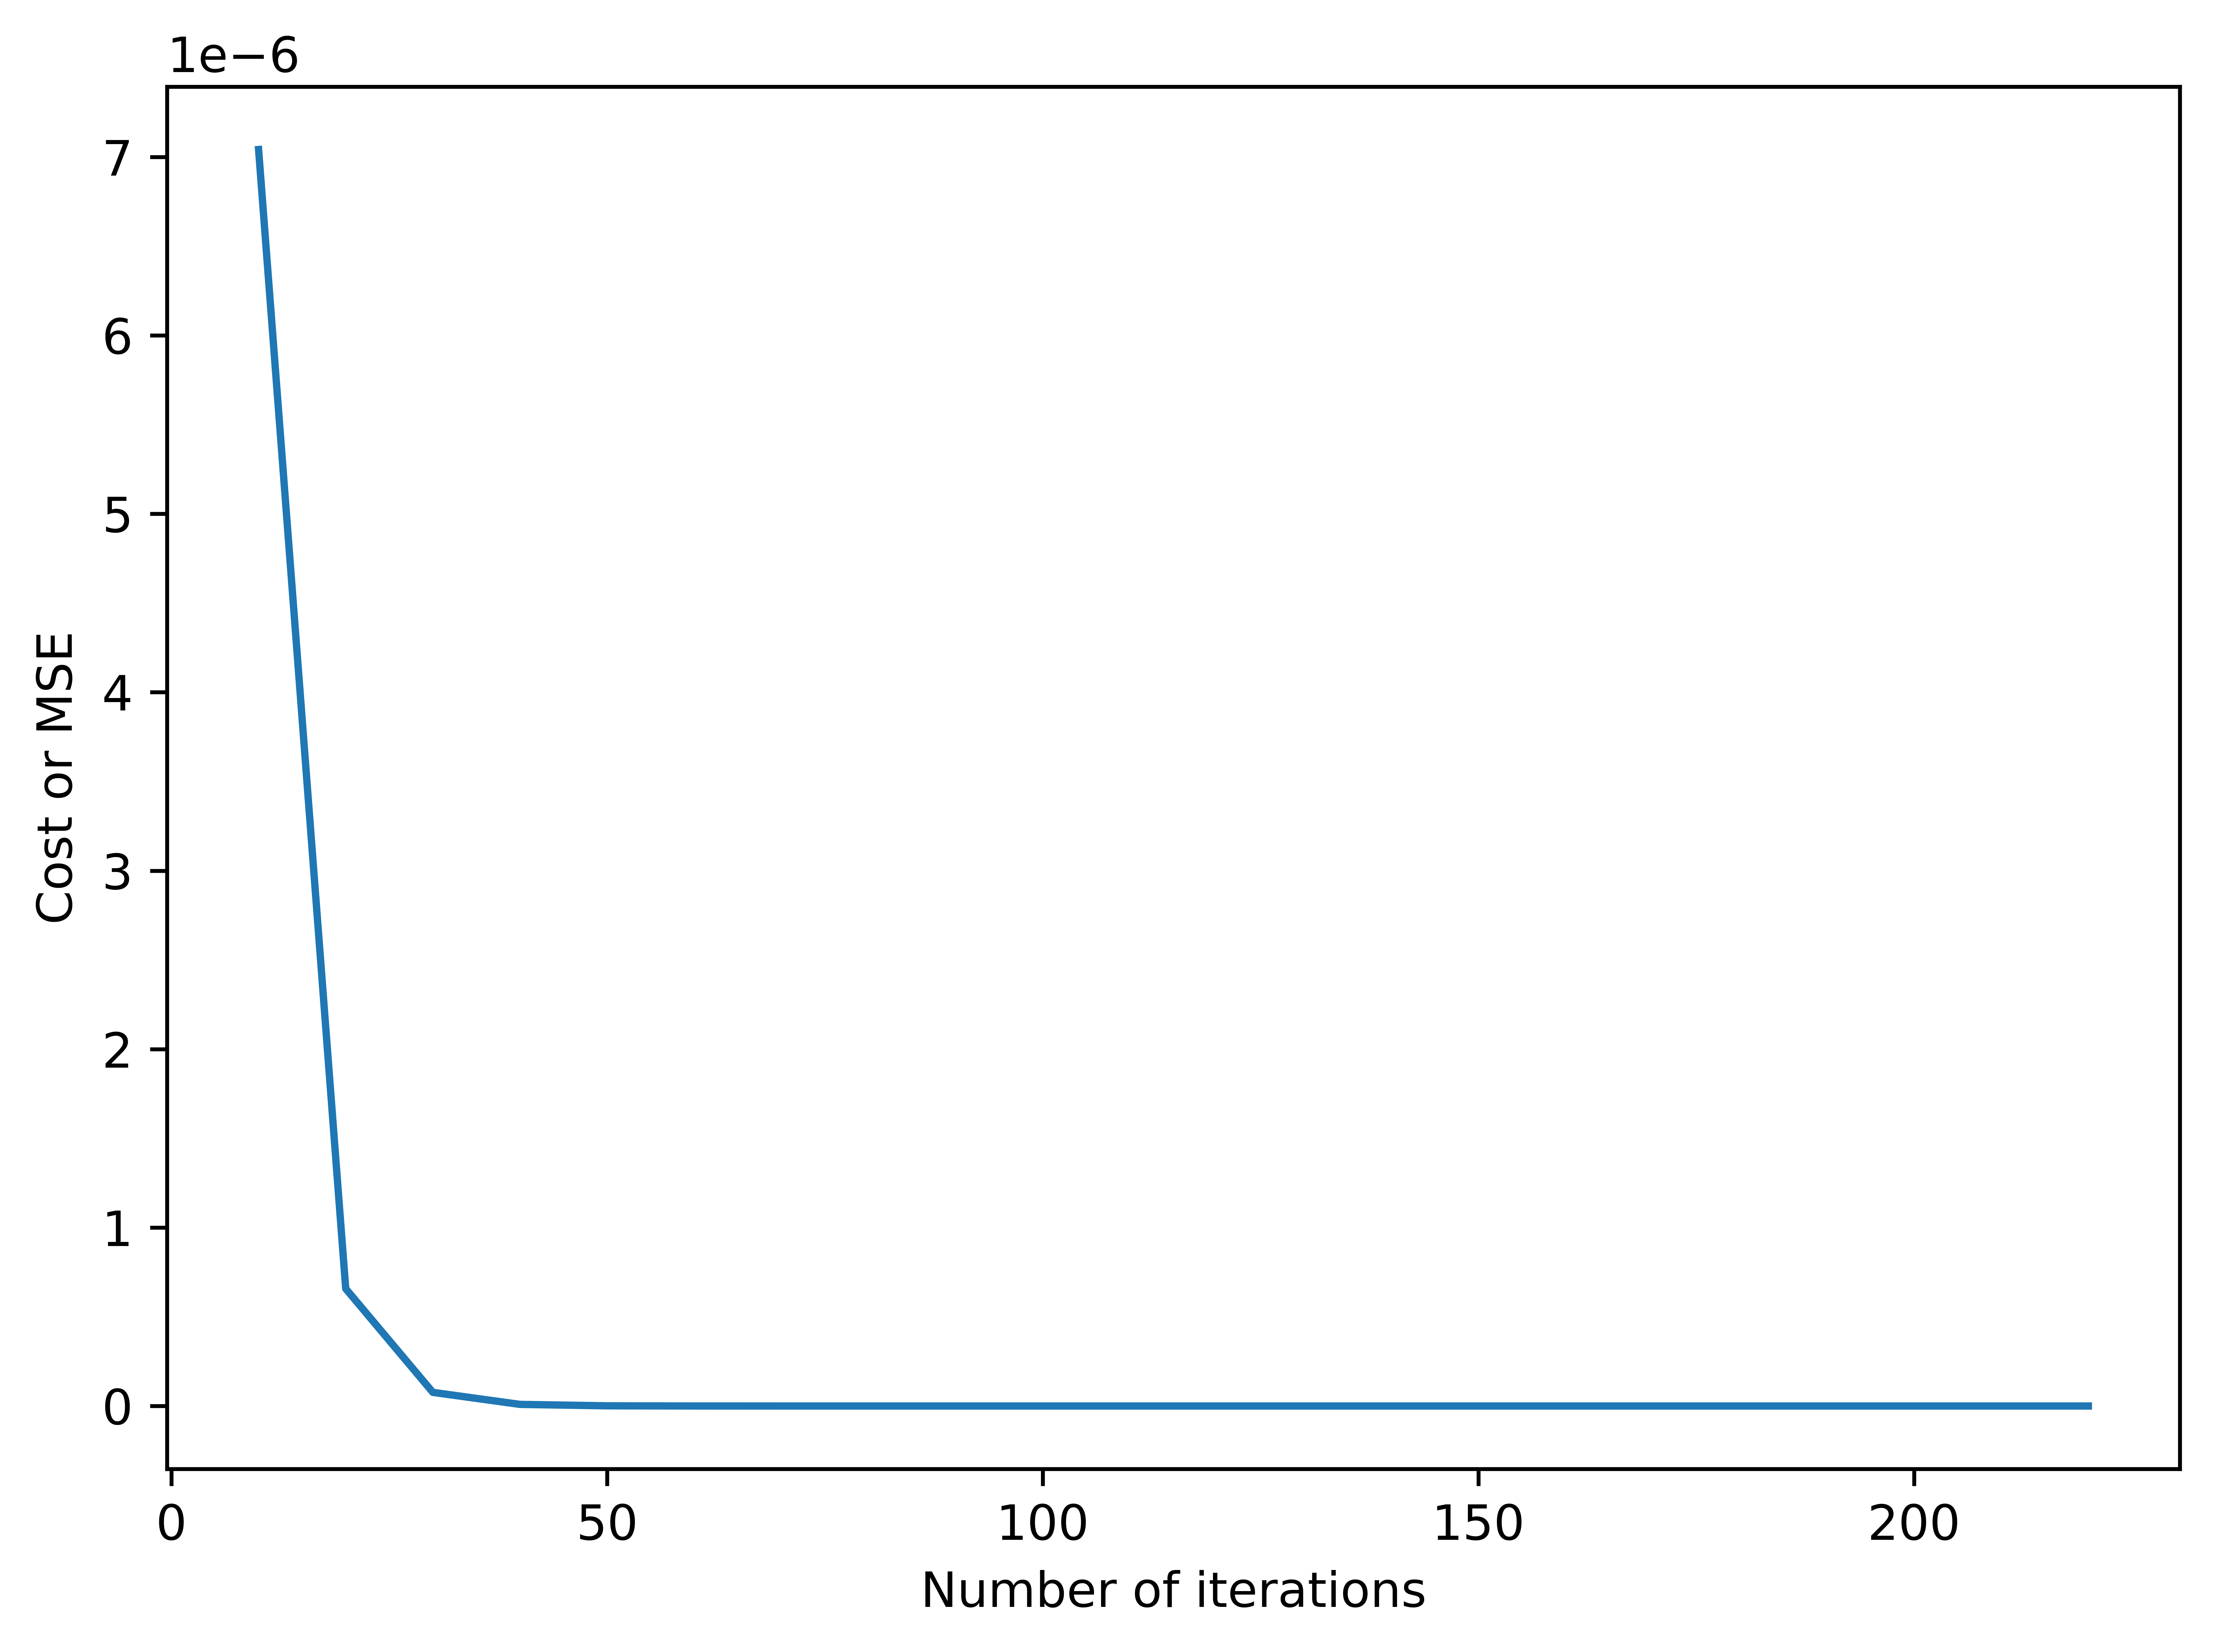

In [58]:
plt.plot(gd_iterations_df['iteration'], gd_iterations_df['cost'])
plt.xlabel('Number of iterations')
plt.ylabel('Cost or MSE')

/var/tmp/pbs.3350535.pbshpc/ipykernel_17474/2729310839.py:103: RuntimeWarning: overflow encountered in multiply
  ES = np.dot(a[k][np.newaxis].T*E*A[k], a[k][np.newaxis])/L[k]
/var/tmp/pbs.3350535.pbshpc/ipykernel_17474/2729310839.py:105: RuntimeWarning: invalid value encountered in add
  K[np.ix_(index,index)] = K[np.ix_(index,index)] + ES
/var/tmp/pbs.3350535.pbshpc/ipykernel_17474/2729310839.py:127: RuntimeWarning: overflow encountered in multiply
  N = E*A[:]/L[:]*(a[:]*u[:]).sum(axis=1)
/var/tmp/pbs.3350535.pbshpc/ipykernel_17474/2729310839.py:128: RuntimeWarning: invalid value encountered in multiply
  R = (Krf[:]*Uf).sum(axis=1) + (Krr[:]*Ur).sum(axis=1) #Reaction Force
/home/civil/visitor/amanp.visitor/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/var/tmp/pbs.3350535.pbshpc/ipykernel_17474/2729310839.py:135: RuntimeWarning: overflow encountered in m

Final Estimate of b and theta :  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
Final Estimate of b and theta :  [-6.94187234e+203 -6.94187234e+203 -6.94187234e+203 -6.94187234e+203
 -6.94187234e+203 -6.94187234e+203 -6.94187234e+203 -6.94187234e+203
 -6.94187234e+203 -6.94187234e+203] [-7.98315319e+204 -7.98315319e+204 -7.98315319e+204 -7.98315319e+204
 -7.98315319e+204 -7.98315319e+204 -7.98315319e+204 -7.98315319e+204
 -7.98315319e+204 -7.98315319e+204]


Text(0.5, 1.0, 'Cost Vs. Iterations for different alpha values')

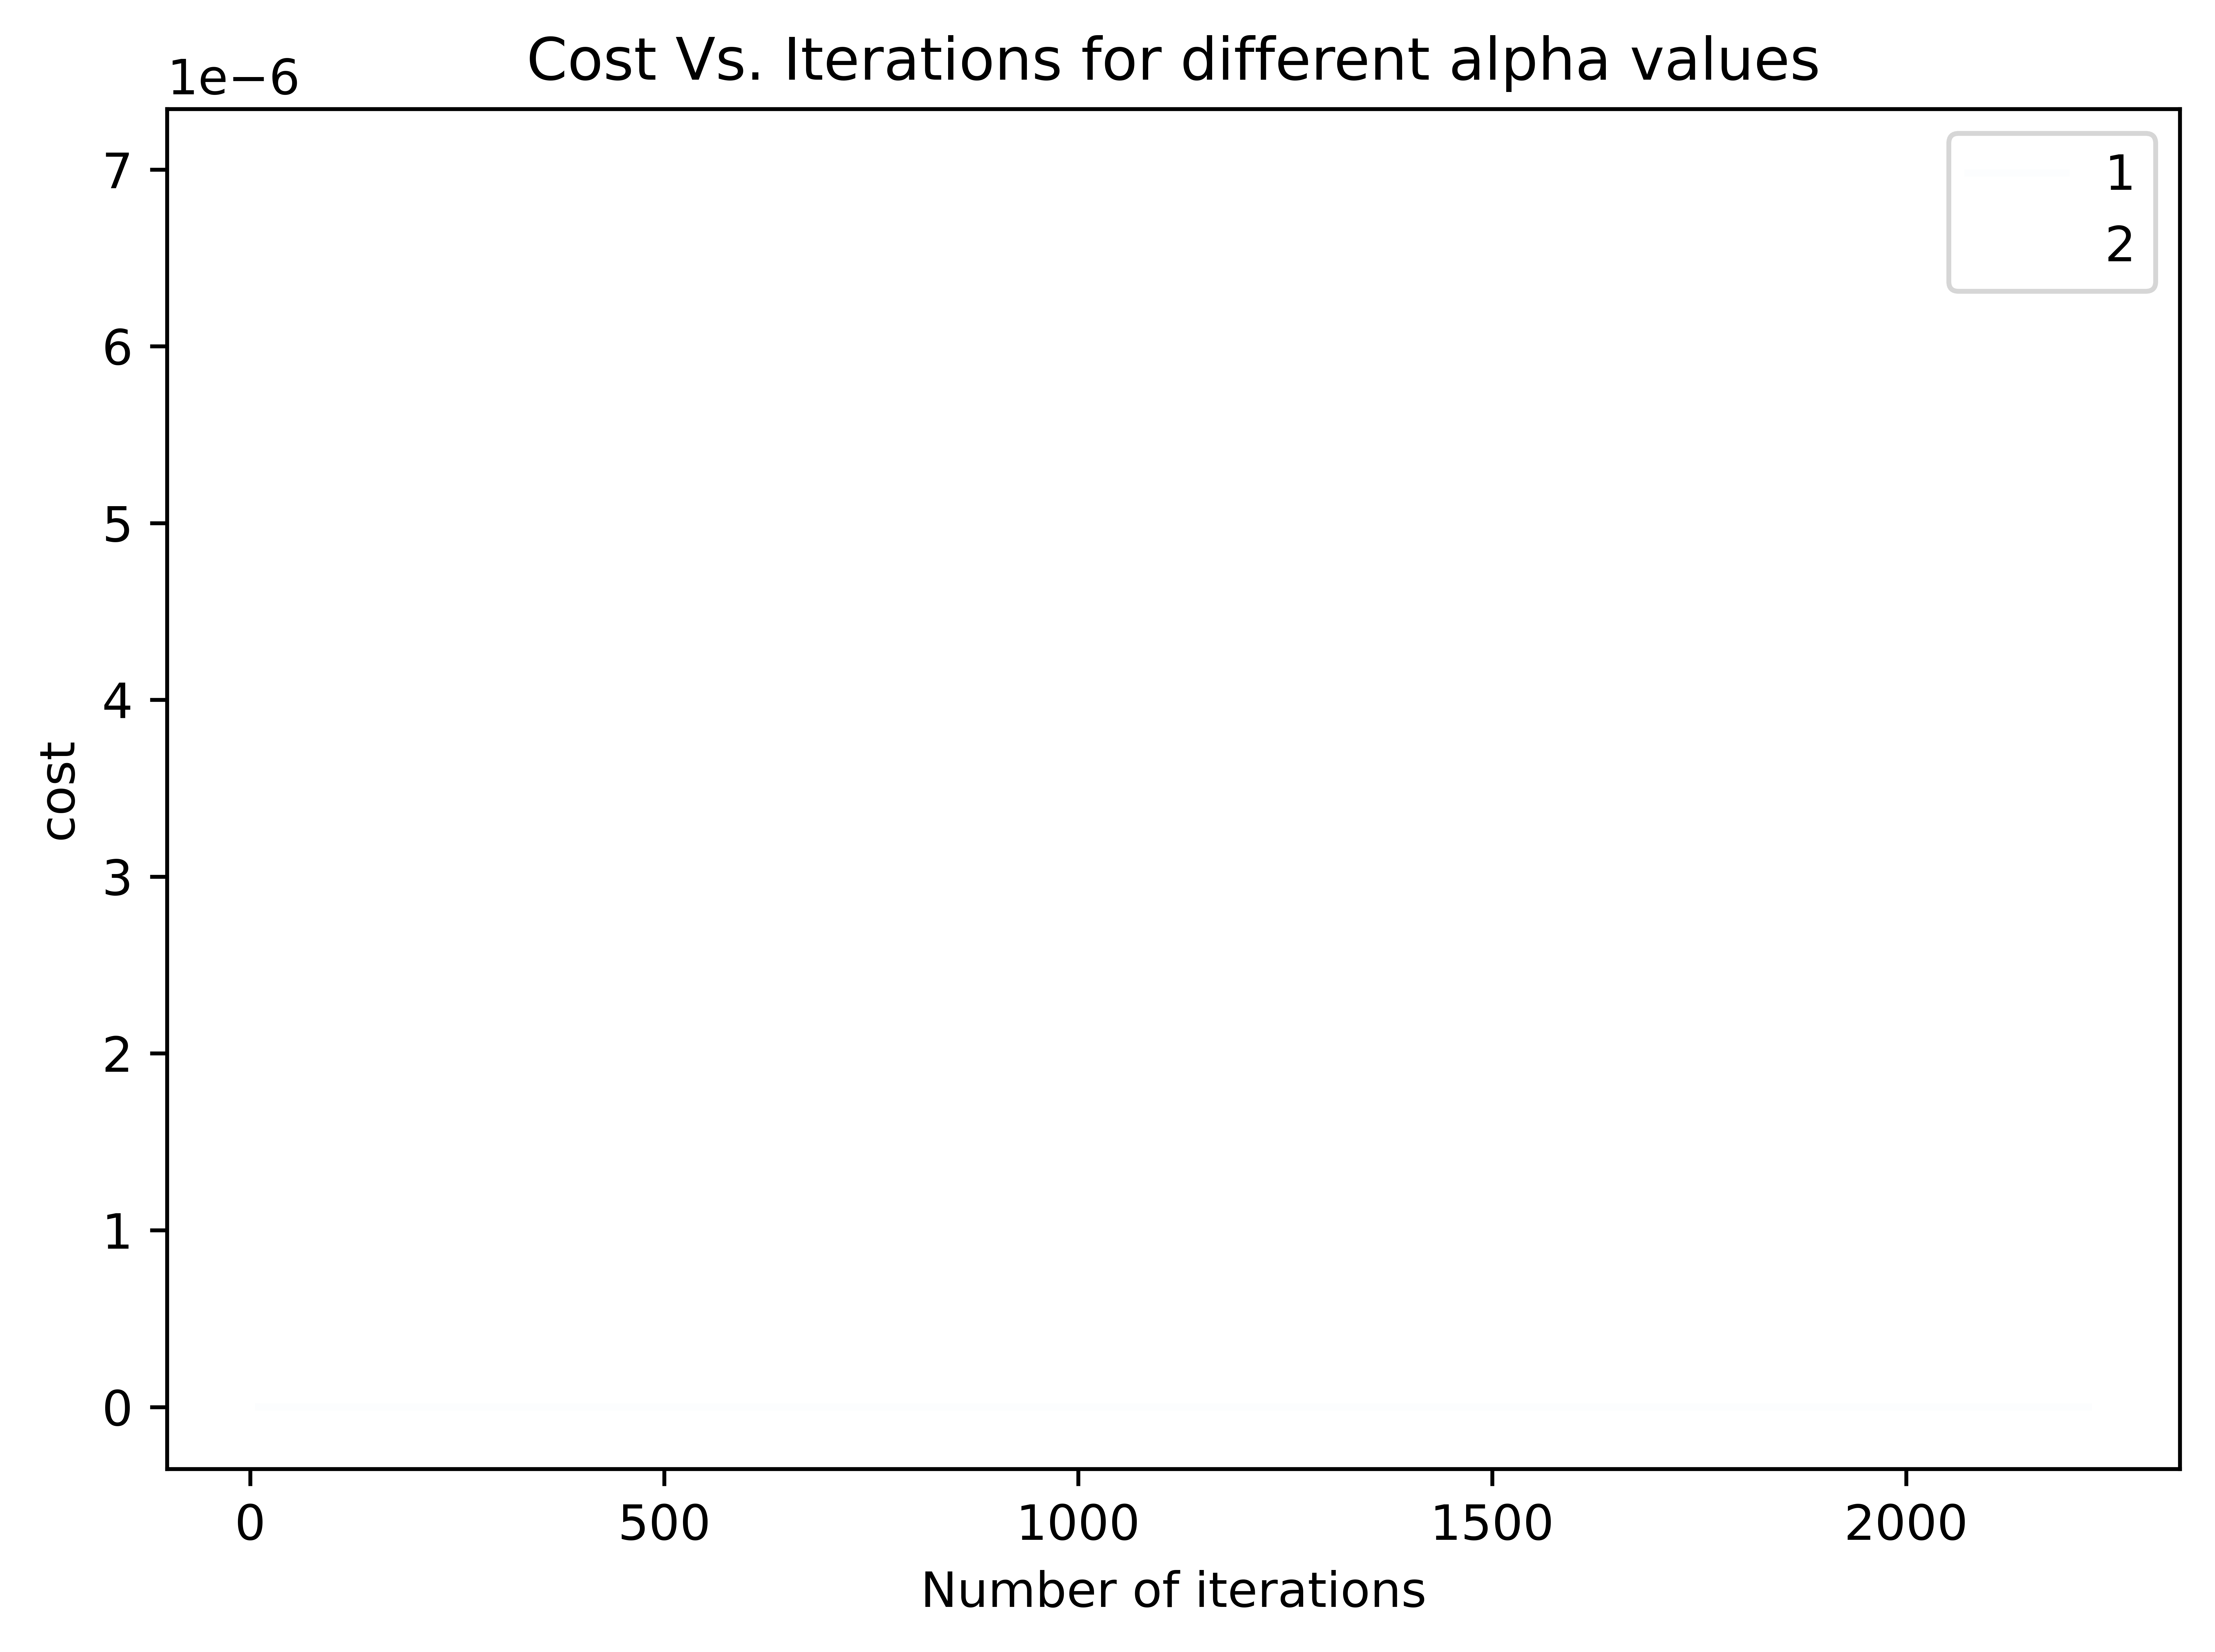

In [59]:
alpha_df_1, b, theta=run_gradient_descent(a,alpha=0.01,num_iterations=2000)
alpha_df_2, b, theta=run_gradient_descent(a,alpha=0.001,num_iterations=2000)

plt.plot(alpha_df_1['iteration'],alpha_df_1['cost'],label='1',alpha=0.01)
plt.plot(alpha_df_2['iteration'],alpha_df_2['cost'],label='2',alpha=0.001)

plt.legend()
plt.ylabel('cost')
plt.xlabel('Number of iterations')
plt.title('Cost Vs. Iterations for different alpha values')

In [60]:
import numpy as np

def cost(x):
    return (2*x-5)**2

# def gradient(x):
#     return 4*(2*x-5)*2
def gradient(x):
    return nd.Gradient(cost)(x)

def optimize():
    x = np.random.rand() # initial x value
    learning_rate = 0.1
    max_steps = 20
    for step in range(max_steps):
        # Compute the gradient
        grad = gradient(x)
        
        # Update x using gradient descent
        x -= grad * learning_rate
        
        # Compute the current cost
        cost_value = cost(x)
        
        # Print progress
        # if step % 100 == 0:
        print("Step: {} x: {} Cost: {}".format(step, x, cost_value))

optimize()


Step: 0 x: 2.0518969974730554 Cost: 0.8031852034946516
Step: 1 x: 2.410379399494611 Cost: 0.03212740813978612
Step: 2 x: 2.4820758798989213 Cost: 0.0012850963255915725
Step: 3 x: 2.4964151759797844 Cost: 5.140385302366035e-05
Step: 4 x: 2.499283035195957 Cost: 2.0561541209459045e-06
Step: 5 x: 2.499856607039191 Cost: 8.224616483803995e-08
Step: 6 x: 2.499971321407838 Cost: 3.289846593562353e-09
Step: 7 x: 2.499994264281568 Cost: 1.3159386373434318e-10
Step: 8 x: 2.4999988528563137 Cost: 5.2637545477435376e-12
Step: 9 x: 2.4999997705712627 Cost: 2.1055018207276042e-13
Step: 10 x: 2.4999999541142524 Cost: 8.422007348117986e-15
Step: 11 x: 2.4999999908228503 Cost: 3.3688030696623345e-16
Step: 12 x: 2.49999999816457 Cost: 1.3475213582800781e-17
Step: 13 x: 2.499999999632914 Cost: 5.390082824817678e-19
Step: 14 x: 2.4999999999265827 Cost: 2.1560383465348643e-20
Step: 15 x: 2.4999999999853166 Cost: 8.624049054236032e-22
Step: 16 x: 2.4999999999970632 Cost: 3.449828288025618e-23
Step: 17 x: 2

In [61]:
import numpy as np

def truss_volume(x):
    """Function that calculates the volume of a truss given its variables x"""
    # Assume the truss has the following dimensions:
    a, b, c, d = x[0], x[1], x[2], x[3]
    return a * b * c * d

def truss_volume_derivative(x, var):
    """Function that calculates the derivative of the truss volume with respect to the variable var"""
    h = 1e-8 # Step size
    var_index = var - 1 # Index of the variable in the x array
    x_plus_h = np.array(x)
    x_plus_h[var_index] += h
    x_minus_h = np.array(x)
    x_minus_h[var_index] -= h
    return (truss_volume(x_plus_h) - truss_volume(x_minus_h)) / (2 * h)

# Example usage:
x = [1, 2, 3, 4]
var = 2
derivative = truss_volume_derivative(x, var)
print(f"The derivative of the truss volume with respect to variable {var} is {derivative}")


The derivative of the truss volume with respect to variable 2 is 600000000.0


In [62]:
import numpy as np

class TrussOptimizer:
    def __init__(self, num_bars=10):
        self.num_bars = num_bars
        self.bar_lengths = np.zeros(num_bars)
        self.bar_areas = np.zeros(num_bars)
        self.bar_stiffness = np.zeros(num_bars)
        self.bar_forces = np.zeros(num_bars)
        self.bar_positions = np.zeros((num_bars, 4))
        self.bar_connectivity = np.zeros((num_bars, 2))
        self.cost_history = []
        self.learning_rate = 0.01
        self.max_steps = 1000

    def cost(self):
        """
        Compute the cost (e.g. weight) of the truss based on the current
        shape, size, and topology.
        """
        pass

    def gradient(self):
        """
        Compute the gradient of the cost function with respect to the
        shape, size, and topology parameters.
        """
        pass

    def optimize(self):
        """
        Optimize the shape, size, and topology of the truss using gradient
        descent.
        """
        for step in range(self.max_steps):
            # Compute the gradient
            grad = self.gradient()
            
            # Update the parameters using gradient descent
            self.bar_lengths -= grad[:self.num_bars] * self.learning_rate
            self.bar_areas -= grad[self.num_bars:2*self.num_bars] * self.learning_rate
            self.bar_stiffness -= grad[2*self.num_bars:3*self.num_bars] * self.learning_rate
            self.bar_forces -= grad[3*self.num_bars:4*self.num_bars] * self.learning_rate
            self.bar_positions -= grad[4*self.num_bars:4*self.num_bars+4*self.num_bars] * self.learning_rate
            self.bar_connectivity -= grad[4*self.num_bars+4*self.num_bars:] * self.learning_rate
            
            # Compute the current cost
            cost = self.cost()
            self.cost_history.append(cost)
            
            # Print progress
            if step % 100 == 0:
                print("Step: {} Cost: {}".format(step, cost))


optimizer = TrussOptimizer()
optimizer.optimize()


TypeError: 'NoneType' object is not subscriptable

In [ ]:
import numpy as np

class Optimizer:
    def __init__(self):
        pass

    @staticmethod
    def run(o_problem, ra_parameters, i_steps, r_learning_rate):
        ra_cost = np.zeros(i_steps)
        for i_step in range(i_steps):
            ra_gradient = Optimizer.gradient(o_problem, ra_parameters)
            ra_parameters = ra_parameters - ra_gradient * r_learning_rate
            ra_cost[i_step] = Optimizer.cost(o_problem, ra_parameters)
            if i_step % 100 == 1:
                Optimizer.sketch_truss(o_problem)
            if i_step > 100:
                if ra_cost[i_step] / ra_cost[i_step - 100] > 0.9995:
                    break
        return ra_parameters, ra_cost

    @staticmethod
    def gradient(o_problem, ra_parameters):
        r_epsilon = max(np.abs(ra_parameters)) / 1e6
        r_cost_0 = Optimizer.cost(o_problem, ra_parameters)
        ra_gradient = np.zeros(len(ra_parameters))
        for i_parameter in range(len(ra_parameters)):
            ra_parameters_1 = ra_parameters
            ra_parameters_1[i_parameter] = ra_parameters_1[i_parameter] + r_epsilon
            r_cost_1 = Optimizer.cost(o_problem, ra_parameters_1)
            ra_gradient[i_parameter] = (r_cost_1 - r_cost_0) / r_epsilon
        return ra_gradient

    @staticmethod
    def cost(o_problem, ra_parameters):
        # function to calculate cost
        pass

    @staticmethod
    def sketch_truss(o_problem):
        # function to sketch truss
        pass


# New Start

In [ ]:
import sympy as sym
from sympy import Matrix
#from sympy.abc import x1, x2, x3, x4, x5, x6
from sympy import symbols
from sympy import solve
from sympy import diff

# Define the matrix of global stiffness
def global_stiffness_matrix(nodes, elements, E, A):
    # Create empty matrix with size 2*nodes x 2*nodes
    K = Matrix.zeros(2*len(nodes), 2*len(nodes))
    # Loop through each element
    for element in elements:
        # Define the element stiffness matrix
        k = E * A * Matrix([[1, -1], [-1, 1]])
        # Define the element displacement matrix
        u = Matrix([x[element[0]], y[element[0]], x[element[1]], y[element[1]]])
        # Define the element rotation matrix
        R = Matrix([[-1, 0, 1, 0], [0, -1, 0, 1]])
        # Add the element stiffness matrix to the global stiffness matrix
        K[2*element[0]:2*element[0]+2, 2*element[0]:2*element[0]+2] += R.T * k * R
    return K

# Define the load vector
def load_vector(nodes, loads):
    # Create empty vector with size 2*nodes x 1
    F = Matrix.zeros(2*len(nodes), 1)
    # Loop through each load
    for load in loads:
        F[2*load[0]] = load[1]
        F[2*load[0]+1] = load[2]
    return F

# Define the displacement matrix
def displacement_matrix(nodes, supports):
    # Create empty matrix with size 2*nodes x 1
    U = Matrix.zeros(2*len(nodes), 1)
    # Loop through each support
    for support in supports:
        U[2*support[0]] = support[1]
        U[2*support[0]+1] = support[2]
    return U

# Define the boundary condition matrix
def boundary_condition_matrix(nodes, supports):
    # Create empty matrix with size 2*nodes x 2*nodes
    B = Matrix.zeros(2*len(nodes), 2*len(nodes))
    # Loop through each support
    for support in supports:
        B[2*support[0], 2*support[0]] = 1
        B[2*support[0]+1, 2*support[0]+1] = 1
    return B

# Truss analysis
def truss_analysis(nodes, elements, E, A, loads, supports):
    K = global_stiffness_matrix(nodes, elements, E, A)
    F = load_vector(nodes, loads)
    B = boundary_condition_matrix(nodes, supports)
    U_bc = displacement_matrix(nodes, supports)
    U = B * U_bc + (B.inv() * (F - K * U_bc))
    return U

# Define the function to optimize
from scipy.optimize import minimize

# Define the function to optimize
def optimize_area(area, nodes, elements, E, loads, supports):
    U = truss_analysis(nodes, elements, E, area, loads, supports)
    stress = []
    for element in elements:
        u = Matrix([U[2*element[0]], U[2*element[0]+1], U[2*element[1]], U[2*element[1]+1]])
        R = Matrix([[-1, 0, 1, 0], [0, -1, 0, 1]])
        stress.append(E*(R*u)[0])
    return max(stress)

# Define the initial area
A = symbols("A")

# Define the optimization constraints
constraints = [A>0]

# Define the optimization bounds
bounds = [(0, None)]

# Minimize the area using the method of gradient descent
result = minimize(optimize_area, 1, args=(nodes, bars, E, P, DOFCON), constraints=constraints, bounds=bounds, method='SLSQP')

# Print the optimized area
print("Optimized area: ", result.x)


In [25]:
import numpy as np
from scipy.optimize import minimize

# Define nodes and bars
nodes, bars = [], []
nodes.append([100,460]) #node0
nodes.append([460,460]) #node1
nodes.append([820,460]) #node2
nodes.append([100,100]) #node3
nodes.append([460,100]) #node4
nodes.append([820,100]) #node5

bars.append([0,1]) #bar1  #dont forget python starts with 0
bars.append([1,2]) #bar2
bars.append([3,4]) #bar3
bars.append([4,5]) #bar4
bars.append([1,4]) #bar5
bars.append([2,5]) #bar6
bars.append([0,4]) #bar7
bars.append([1,3]) #bar8
bars.append([1,5]) #bar9
bars.append([2,4]) #bar10

nodes = np.array(nodes).astype(float)
bars = np.array(bars)
original_nodes = np.copy(nodes)

# Define optimization function
def truss_optimize(x):
    global nodes, bars, original_nodes
    nodes[:, 0] = original_nodes[:, 0] + x[:len(nodes)]
    nodes[:, 1] = original_nodes[:, 1] + x[len(nodes):]
    stress = []
    for i in range(len(bars)):
        bar_nodes = bars[i]
        x1, y1 = nodes[bar_nodes[0]]
        x2, y2 = nodes[bar_nodes[1]]
        L = np.sqrt((x2-x1)**2 + (y2-y1)**2)
        f = x[-1]
        stress.append(f/L)
    return sum(np.square(stress))

# Define optimization bounds
bounds = [(None, None)] * len(nodes) * 2 + [(0, None)]

# Run optimization
result = minimize(truss_optimize, [0.0]*(len(nodes)*2 + 1), method='L-BFGS-B', bounds=bounds)


ValueError: operands could not be broadcast together with shapes (6,) (7,) 